# Forex Trading Strategy Analysis and Simulation

## Project Overview

This project presents a comprehensive analysis and simulation of a Forex trading strategy using historical EUR/USD data. Leveraging both CPU and GPU-accelerated libraries, the workflow encompasses data preprocessing, feature engineering, model training with XGBoost, performance evaluation, and Monte Carlo simulations to project future trading outcomes. The objective is to develop a robust machine learning model that can predict trading signals (Buy, Sell, Hold) and assess the strategy's effectiveness through detailed performance metrics and simulations.

## Workflow Summary

1. **Importing Libraries and Configurations**

   Load essential libraries for data processing (`pandas`, `cudf`, `cupy`), modeling (`xgboost`), evaluation (`scikit-learn`), and visualization (`matplotlib`).

   Configure display settings and verify the RAPIDS cuDF library version.

2. **Defining Parameters and Date Ranges**

   Set date ranges for training (`2022-01-01` to `2022-12-31`), validation (`2023-01-01` to `2023-05-31`), and testing (`2023-06-01` to `2023-10-31`) datasets.

   Establish trading hours, profit targets, stop-loss parameters, leverage factors, and simulation settings.

3. **Data Loading and Initial Preprocessing**

   Load Forex data from a Parquet file into a GPU-accelerated cuDF DataFrame.

   Filter data based on extended date ranges and specific trading conditions (currency pair: EUR/USD, timeframe: 10 minutes).

4. **Feature Engineering**

   Generate lagged features to incorporate historical data.

   Create time-based features (e.g., working hours, day of the week) to capture temporal patterns.

   Develop target variables (`Y`) based on profit target and stop-loss conditions, labeling trades as **Buy (1)**, **Sell (2)**, or **Hold (0)**.

   Construct ratio-based features to enhance model input with relationships between different indicators.

5. **Feature Selection and Correlation Analysis**

   Identify and remove highly correlated features (correlation coefficient > 0.95) to mitigate multicollinearity and improve model performance.

6. **Data Splitting and Scaling**

   Split the data into training, validation, and test sets based on predefined date ranges.

   Apply robust scaling to feature matrices to handle outliers and ensure uniform feature contribution.

7. **Model Training with XGBoost**

   Define hyperparameters tailored for multi-class classification using XGBoost.

   Train the model with early stopping based on validation loss to prevent overfitting.

   Visualize training and validation loss progression over boosting rounds.

8. **Model Evaluation**

   Generate classification reports for training, validation, and test datasets, detailing **precision, recall, f1-score**, and **support** for each class.

   Analyze precision and recall across different probability thresholds to determine optimal classification thresholds for **Buy** and **Sell** signals.

9. **Trading Simulation**

   Simulate trading based on model predictions, tracking correct trades, total trades, and capital progression.

   Calculate performance metrics such as **average daily return, standard deviation, and Sharpe Ratio**.

   Visualize the value progression over time based on trading activities.

10. **Monte Carlo Simulations**

    Conduct Monte Carlo simulations to project the distribution of final capital after a specified number of years.

    Analyze simulation results through histograms and capital progression plots to assess potential financial outcomes.

11. **Visualization and Reporting**

    Create various plots to visualize model performance, trade accuracy over time, precision-recall trade-offs, and simulation distributions.

    Summarize findings and insights derived from the analysis.

## Objectives

- **Predictive Modeling:** Develop a machine learning model capable of accurately predicting Buy and Sell signals in Forex trading.
- **Performance Evaluation:** Assess the model's effectiveness using classification metrics and analyze trading strategy performance through simulations.
- **Risk Assessment:** Utilize Monte Carlo simulations to understand potential financial risks and returns associated with the trading strategy.
- **Visualization:** Provide clear and informative visualizations to communicate results and support decision-making.

## Tools and Technologies

- **Programming Language:** Python
- **Libraries:** `pandas`, `cudf`, `cupy`, `xgboost`, `scikit-learn`, `matplotlib`, `joblib`
- **Environment:** GPU-accelerated computing with RAPIDS cuDF for efficient data processing

# Importing Required Libraries

This section imports all necessary libraries for data processing, modeling, evaluation, and visualization. Both CPU and GPU-accelerated libraries are utilized to enhance performance. 


In [135]:
import pandas as pd, numpy as np # CPU libraries
import cudf # GPU libraries
import cupy as cp
import gc
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
import time
import matplotlib.pyplot as plt
import itertools
import warnings
from sklearn.preprocessing import RobustScaler
from datetime import timedelta
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from itertools import product
pd.set_option('display.max_columns', None)
import random
random.seed(42)
print('RAPIDS version',cudf.__version__)

RAPIDS version 24.06.01


# Defining Date Ranges for Data Splitting

Specify the date ranges for training, validation, and testing datasets. These ranges are neede for segregating the data to evaluate the model's performance on unseen data.

In [54]:
# Define the date ranges for training, validation, and testing
train_start_date = '2022-01-01'
train_end_date = '2023-03-31'
valid_start_date = '2023-04-01'
valid_end_date = '2023-09-30'
test_start_date = '2023-10-01'
test_end_date = '2024-03-31'

# Setting Trading Hours

Define the start and end hours for trading activities. These parameters help in filtering trades within specific time windows.

In [55]:
# Trading hours
hr_st = 10
hr_end = 15

# Configuring Trading Strategy Parameters

Set the parameters for profit targets (PT), stop loss (SL), spread, timeframes, and leverage. These parameters are needed for simulating trading strategies and risk management.

In [56]:
# Parameters for profit target (PT) and stop loss (SL)
PT = 0.06 / 100  # Profit target (0.06%)
SL = 0.06 / 100  # Stop loss (0.06%)
spread = 0.0002  # Spread value - very conservative
end_of_day_hour = hr_end  # Use hr_end as the cutoff for end of day
tf = 10  # Timeframe in minutes (10 minutes)
max_hold_time = 180 / tf  # Maximum holding time in periods (e.g., 180 minutes / 10 minutes = 18 periods)

# Defining Filters for Currency Pair and Timeframe

Specify the currency pair and the timeframe to filter the dataset accordingly. We will trade EUR USD on the 10M timeframe

In [57]:
# Define filters for currency pair and time data
currency_pair = "EURUSD"
timeframe_10M = "M10"

# Setting Initial Values and Simulation Parameters

Initialize variables for simulation, including starting capital, leverage, maximum trades per day, minimum hours between trades, trading days per year, and the projection period in years.

In [58]:
# For plotting at end
initial_value = 1000  # Starting value
leverage = 10  # Leverage factor (e.g., 10x leverage)
max_trades_per_day = 4  # Set the maximum number of trades per day
min_hours_between_trades = max(max_hold_time*tf/60,1)  # Minimum hours required between consecutive trades
trading_days_per_year = 252 * 0.55  # Approximate number of trading days per year, active 55% of that time
years = 7

# Calculating Extended Date Range for Data Filtering

Extend the original date ranges to include additional data for feature engineering and model training. This helps in capturing trends and patterns leading up to the defined periods.

In [59]:
# Calculate the extended date range
filter_start_date = (pd.to_datetime(train_start_date) - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
filter_end_date = (pd.to_datetime(test_end_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

# Defining the Path to the Data File

Specify the file path to the Parquet file containing Forex data. Please refer to ETL to Parquet ETL script for features pulled.

In [60]:
# Define the path to the Parquet file
parquet_file_path = "../../data/Forex/single_file_forex_data.parquet"

# Loading and Filtering Data with cuDF

Load the Forex data from the Parquet file into a cuDF DataFrame for GPU-accelerated processing. Filter the data based on the extended date range to focus on relevant periods.

In [61]:
# Load the Parquet file into a cuDF DataFrame
gdf = cudf.read_parquet(parquet_file_path)

In [62]:
# Filter the DataFrame to drop rows where the date index is before some date
gdf = gdf.loc[(gdf.index >= filter_start_date) & (gdf.index <= filter_end_date)]

In [63]:
# Print the minimum and maximum dates in the DataFrame
print("Minimum date in gdf:", gdf.index.min())
print("Maximum date in gdf:", gdf.index.max())

Minimum date in gdf: 2021-12-01T00:00:00.000000000
Maximum date in gdf: 2024-04-01T00:00:00.000000000


In [64]:
gc.collect()

0

# Filtering Data for Specific Timeframe, Currency Pair and Features - refer to forex_etl_to_parquet.py for creation of features

Extract data for the specified currency pair and timeframe (e.g., EURUSD with a 10-minute interval).

In [65]:
# Define the selected feature list
selected_features = [
    'currency_pair', 'timeframe', 'OPEN', 'HIGH','LOW', 'CLOSE', # Essential columns
    
    # Momentum Indicators
    'RSI_14', 'RSI_7',
    'MACD_12_26_9', 'MACD_SIGNAL_12_26_9', 'MACD_HIST_12_26_9',
    'STOCHk_14_3_3', 'STOCHd_14_3_3',
    'CCI_14', 'CMO_14',
    
    # Trend & Volatility Indicators
    'ADX_14', 'AROON_UP_25', 'AROON_DOWN_25',
    'ICHIMOKU_CONVERSION_9', 'ICHIMOKU_BASE_26',
    'ATR_14', 'PCT_BBANDS_20_2', 'CHOP_14',
    
    # Ratio-based & Returns
    'RATIO_CLOSE_OVER_OPEN', 'RATIO_CLOSE_TO_LOW_10', 'LOGRET_5',

    # Candlestick Patterns
    'cdl_doji', 'cdl_inside'
]
# Filter the cuDF DataFrame for 10M timeframe and select only the chosen columns
DF_10M = gdf[(gdf['currency_pair'] == currency_pair) & (gdf['timeframe'] == timeframe_10M)][selected_features]

# Clean up memory
del gdf
gc.collect()

0

In [66]:
# Forward-fill missing values to prevent look-ahead bias in financial data
DF_10M = DF_10M.ffill()

In [67]:
# Display the filtered DataFrame
print(len(DF_10M))
print(len(DF_10M.columns))

87053
28


In [68]:
print(DF_10M.columns)

Index(['currency_pair', 'timeframe', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'RSI_14',
       'RSI_7', 'MACD_12_26_9', 'MACD_SIGNAL_12_26_9', 'MACD_HIST_12_26_9',
       'STOCHk_14_3_3', 'STOCHd_14_3_3', 'CCI_14', 'CMO_14', 'ADX_14',
       'AROON_UP_25', 'AROON_DOWN_25', 'ICHIMOKU_CONVERSION_9',
       'ICHIMOKU_BASE_26', 'ATR_14', 'PCT_BBANDS_20_2', 'CHOP_14',
       'RATIO_CLOSE_OVER_OPEN', 'RATIO_CLOSE_TO_LOW_10', 'LOGRET_5',
       'cdl_doji', 'cdl_inside'],
      dtype='object')


In [69]:
gc.collect()

0

# Feature Analysis and Visualization: Bollinger Bands % (20,2)
All features in our dataset have already been standardized or transformed for easier interpretability. For example, rather than using raw Bollinger Band values, we use Bollinger Bands % (PCT_BBANDS_20_2), which normalizes the price relative to the upper and lower bands.

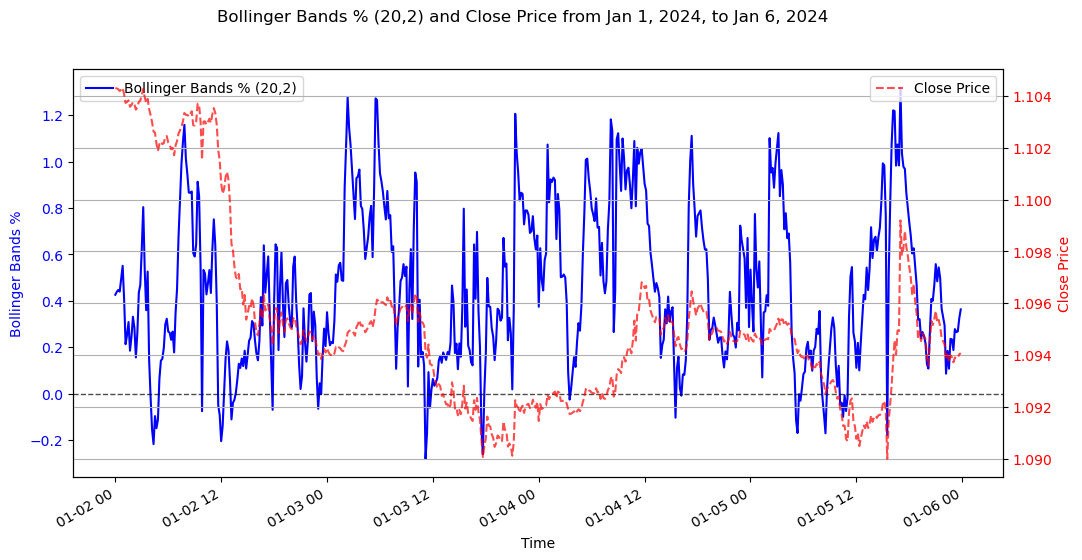

In [70]:
# Filter data for the date range Jan 1, 2024 - Jan 5, 2024
# Filter data for the date range Jan 1, 2024 - Jan 6, 2024
start_date = "2024-01-01"
end_date = "2024-01-06"
DF_sample = DF_10M.loc[(DF_10M.index >= start_date) & (DF_10M.index <= end_date)]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Bollinger Bands Percentage
ax1.plot(DF_sample.index, DF_sample['PCT_BBANDS_20_2'], label='Bollinger Bands % (20,2)', color='blue')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)  # Zero line reference
ax1.set_xlabel('Time')
ax1.set_ylabel('Bollinger Bands %', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for CLOSE price
ax2 = ax1.twinx()
ax2.plot(DF_sample.index, DF_sample['CLOSE'], label='Close Price', color='red', linestyle='dashed', alpha=0.7)
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
fig.suptitle('Bollinger Bands % (20,2) and Close Price from Jan 1, 2024, to Jan 6, 2024')
fig.autofmt_xdate()  # Auto-format x-axis labels for readability
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

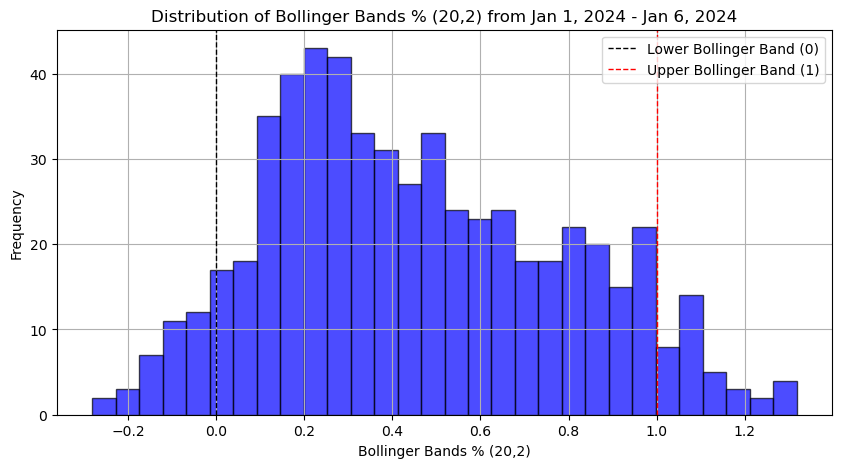

In [71]:
# Plot histogram for Bollinger Bands Percentage
plt.figure(figsize=(10, 5))
plt.hist(DF_sample['PCT_BBANDS_20_2'].dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)

# Reference lines for lower and upper Bollinger Bands
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, label="Lower Bollinger Band (0)")
plt.axvline(x=1, color='red', linestyle='--', linewidth=1, label="Upper Bollinger Band (1)")

# Labels and title
plt.xlabel('Bollinger Bands % (20,2)')
plt.ylabel('Frequency')
plt.title('Distribution of Bollinger Bands % (20,2) from Jan 1, 2024 - Jan 6, 2024')
plt.legend()
plt.grid(True)

plt.show()

# Look at dist of the remaining features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


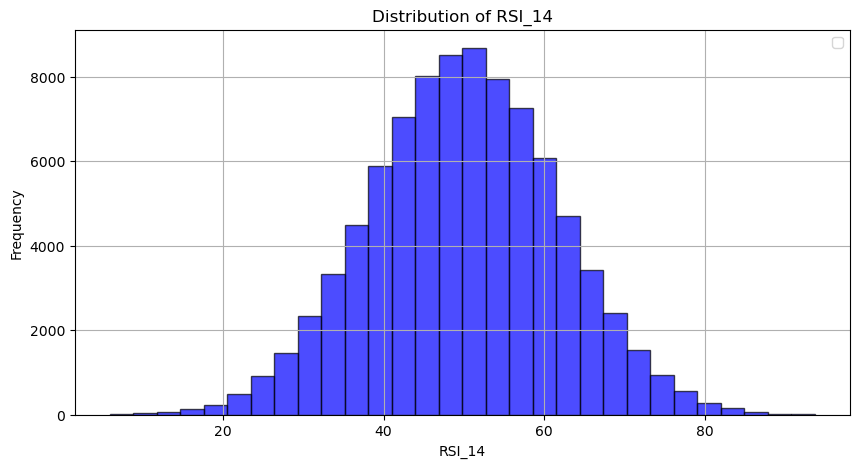

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


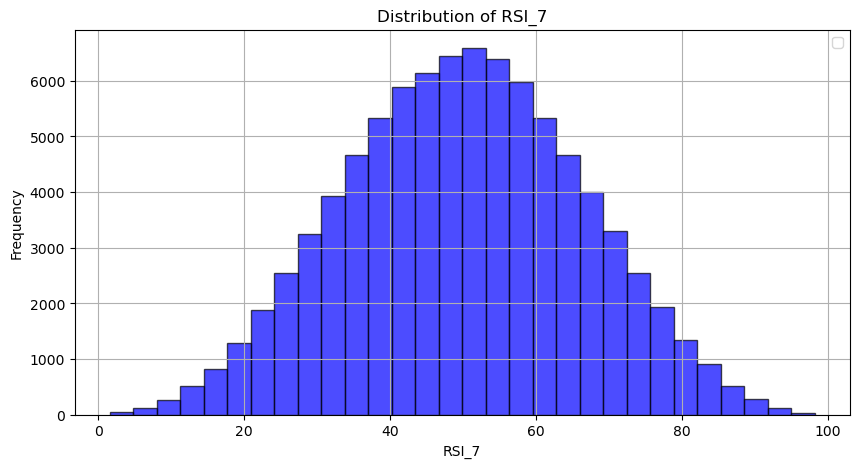

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


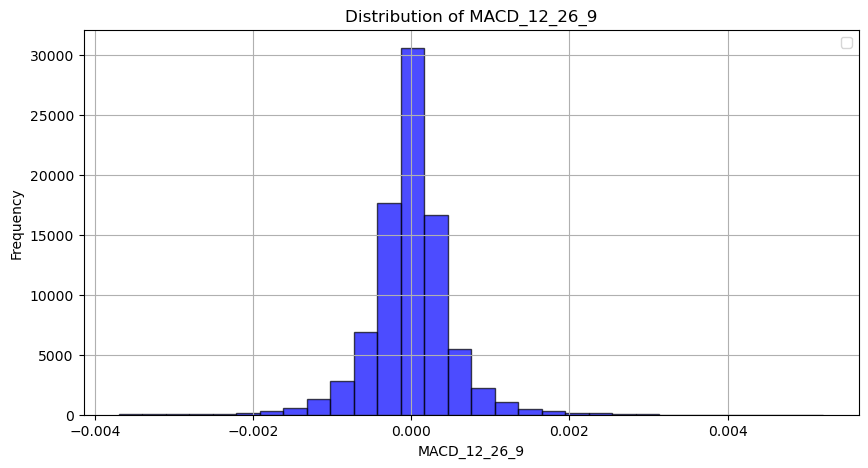

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


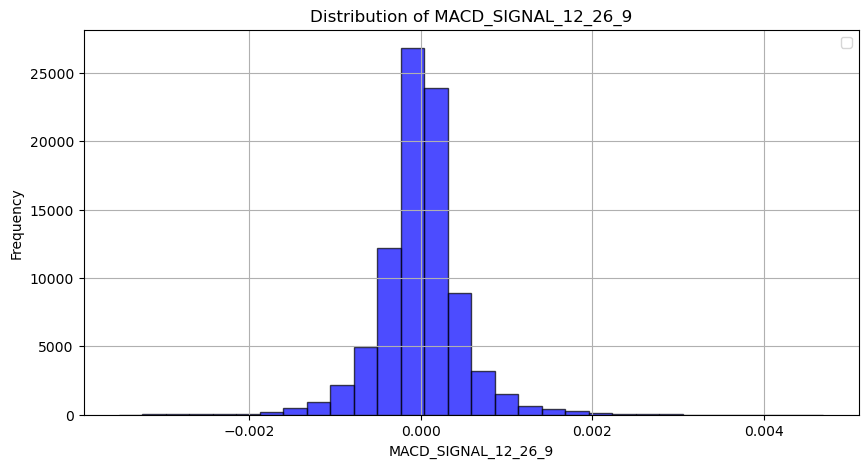

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


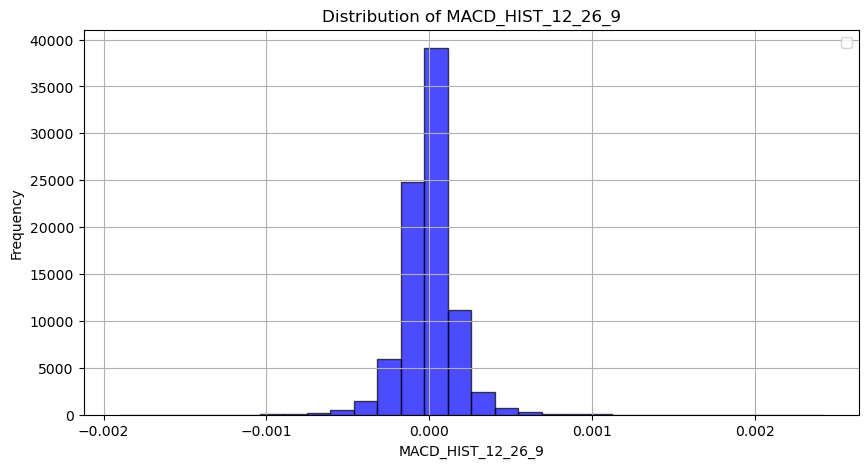

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


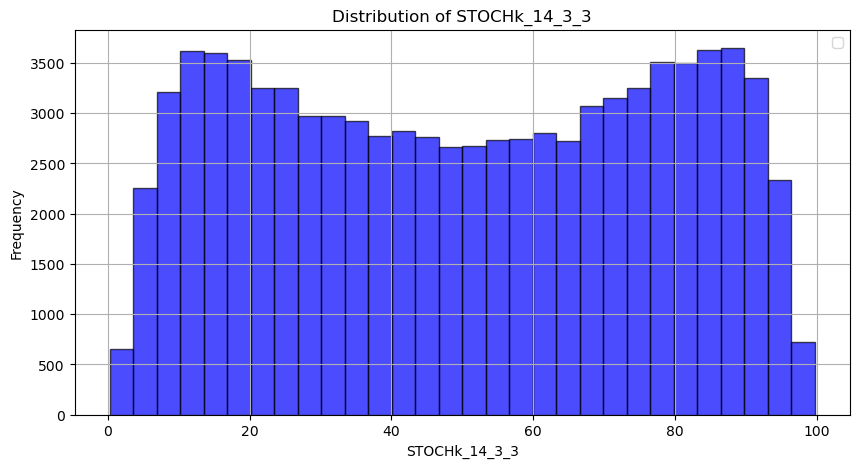

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


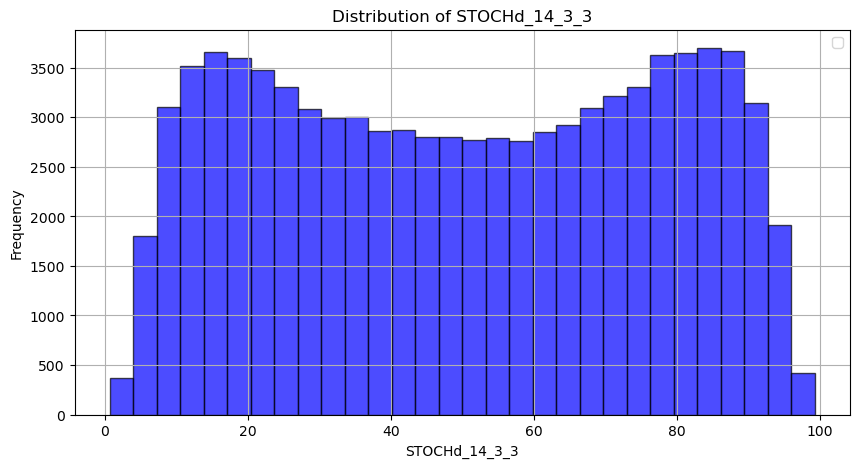

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


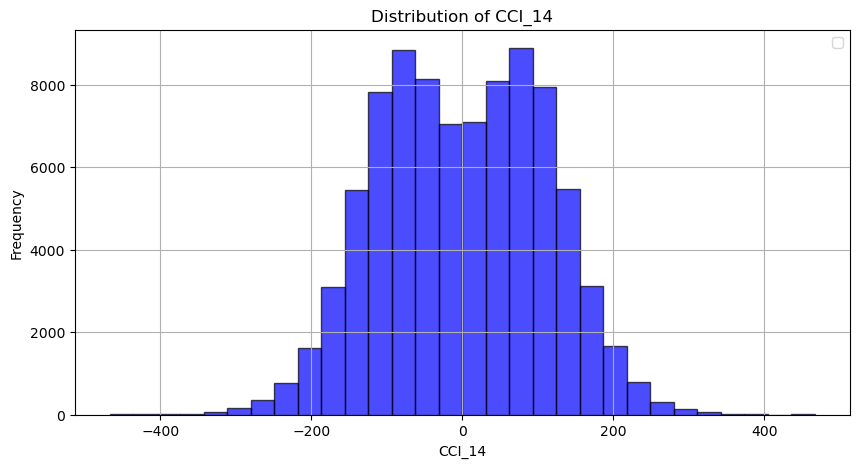

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


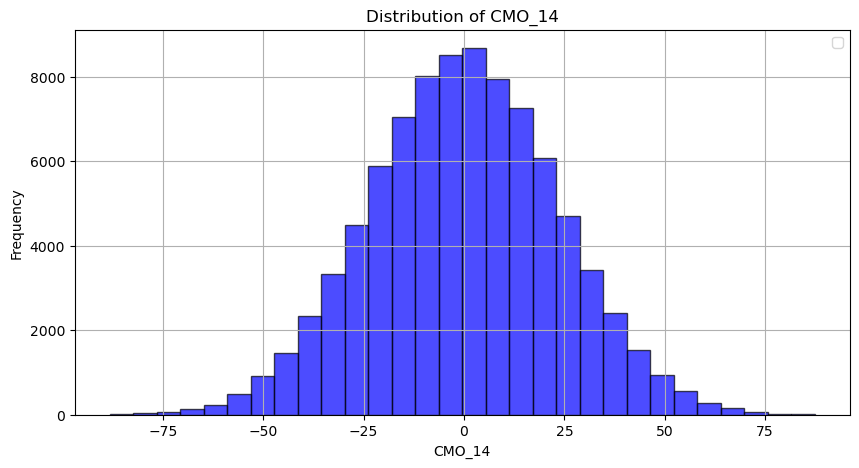

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


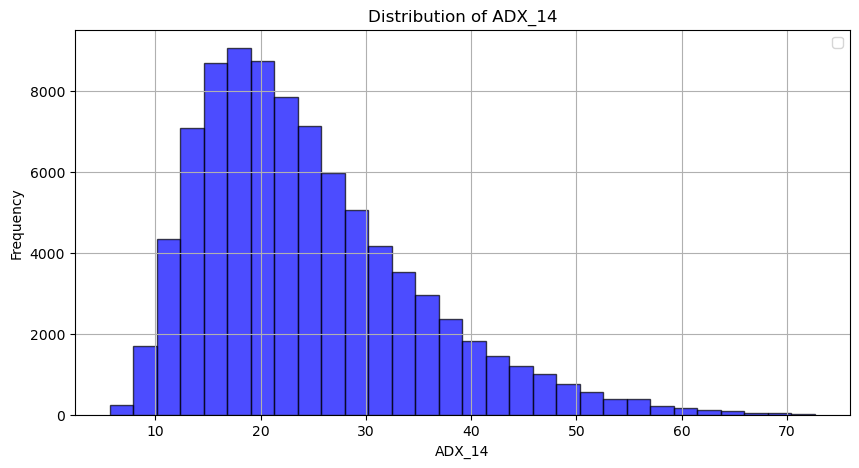

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


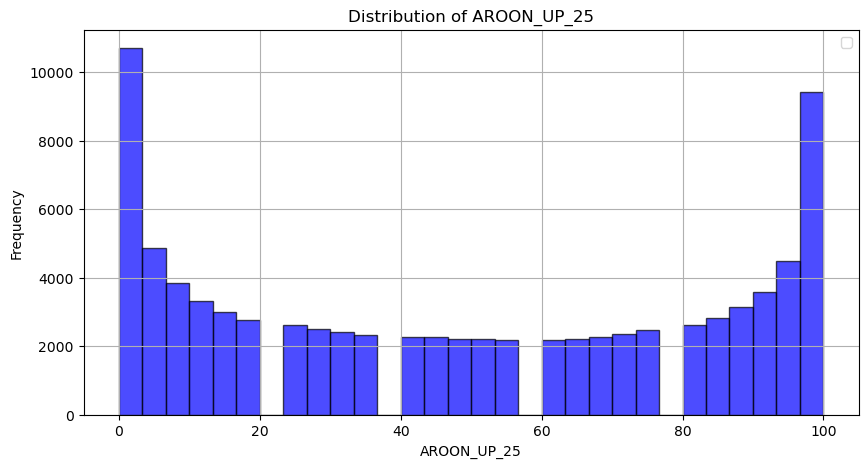

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


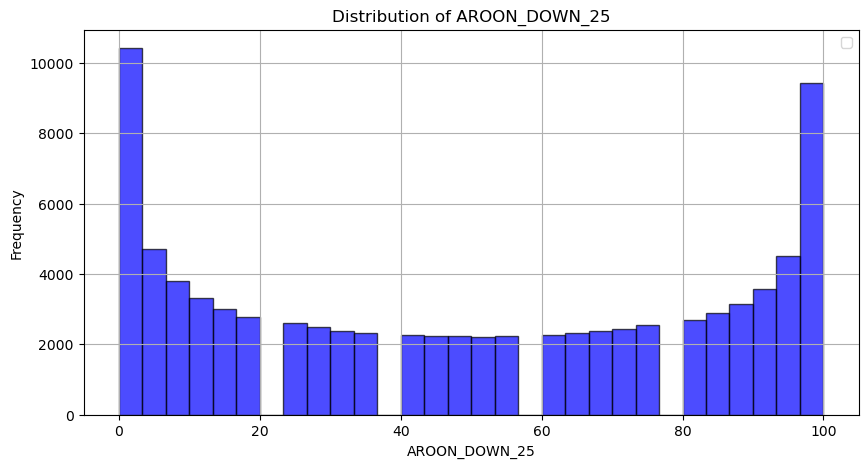

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


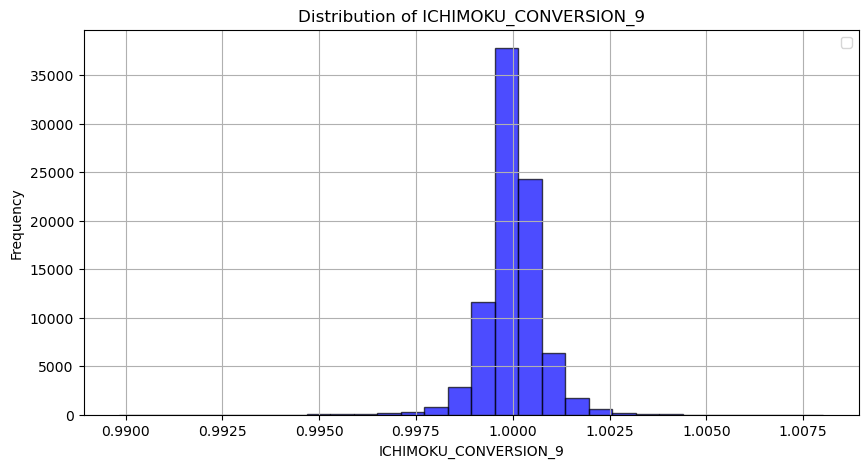

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


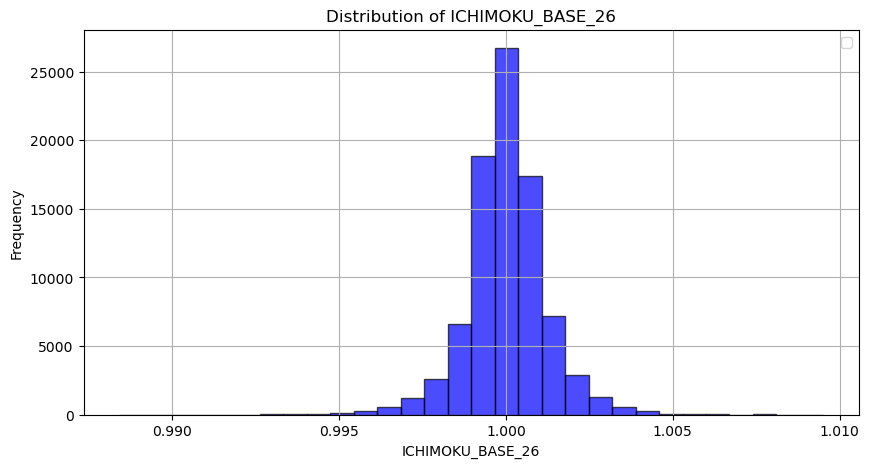

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


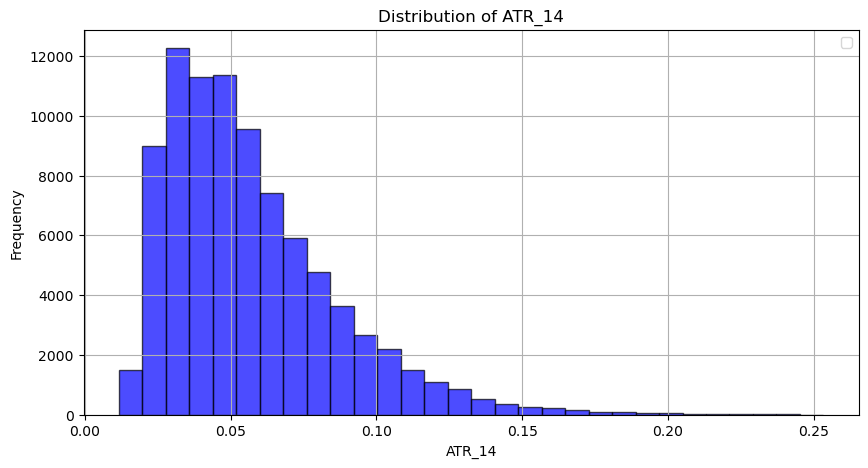

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


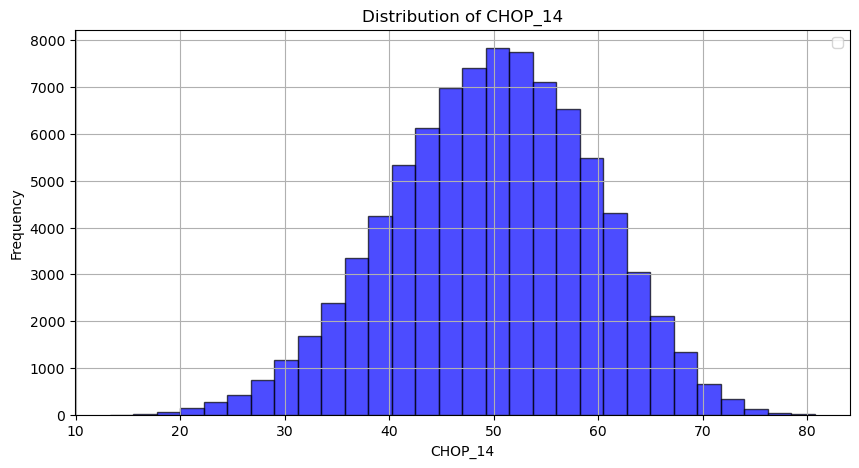

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


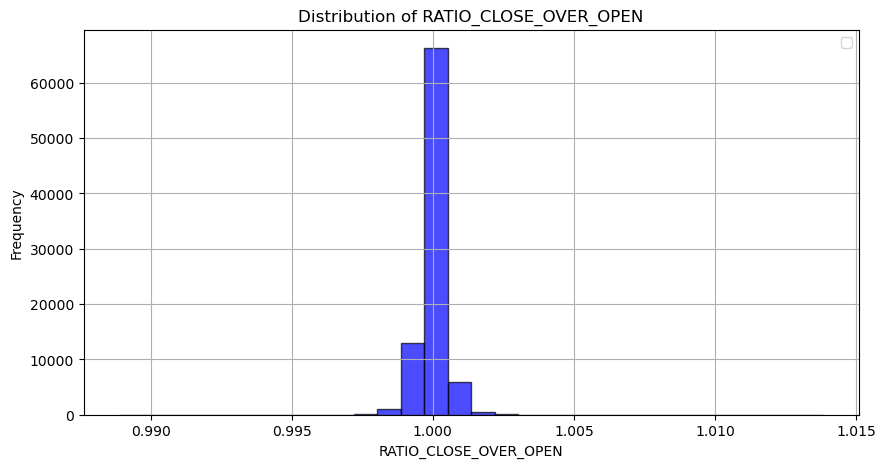

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


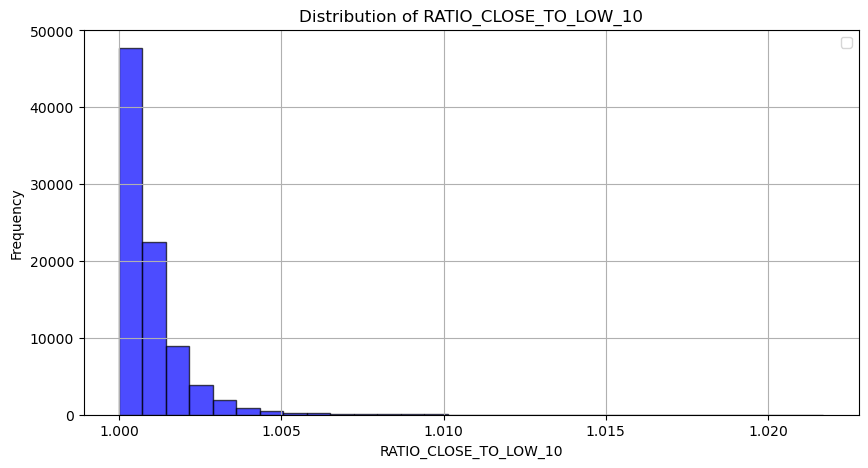

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


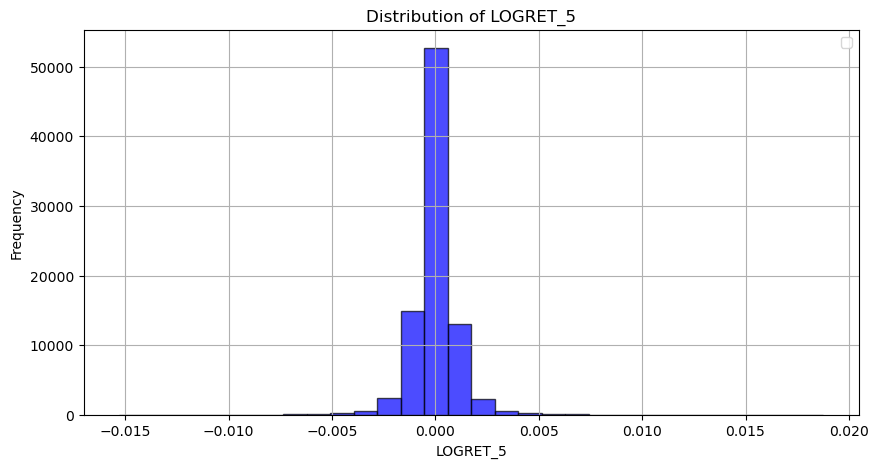

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


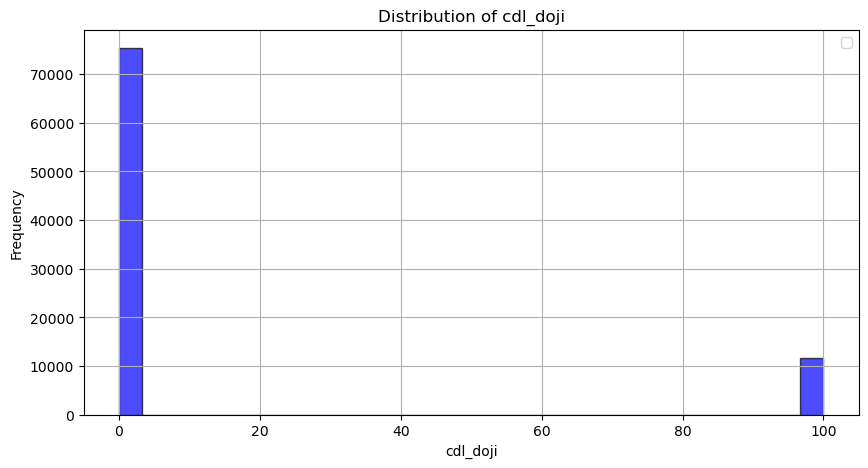

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


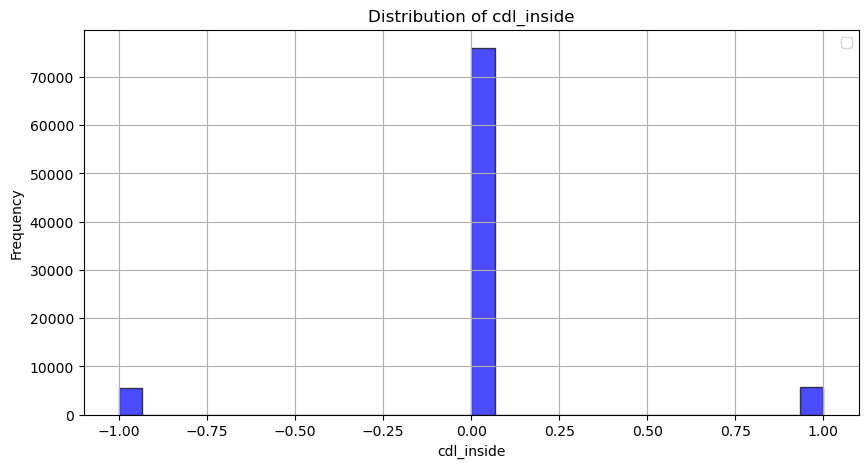

In [72]:
for feature in selected_features:
    if feature not in ['currency_pair', 'timeframe', 'OPEN', 'HIGH','LOW','CLOSE', 'PCT_BBANDS_20_2']: 
        plt.figure(figsize=(10, 5))
        plt.hist(DF_10M[feature].dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)
        
        # Labels and title
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature}')
        plt.legend()
        plt.grid(True)
        
        plt.show()

## We will use robust scaler later!

# Creating Lagged Features for Time Series Analysis

Generate previous period (lagged) features for selected columns to capture historical information. For time series modeling where past values influence future predictions.

In [73]:
# Add previous value columns for 1 to n periods back for existing columns before creating new columns
for col in DF_10M.columns:
    if col not in ['OPEN', 'HIGH','LOW', 'CLOSE', 'currency_pair', 'timeframe', 'DATE']: 
        # Create columns for previous 1 to n periods
        for i in range(1, 2):
            DF_10M[f'prev_{i}_{col}'] = DF_10M[col].shift(i)

# Assigning the Filtered DataFrame and Sorting

Assign the filtered DataFrame to a new variable `DF` and ensure that the index is sorted chronologically to maintain the correct order of time series data.

In [74]:
DF = DF_10M
# Ensure the index is sorted chronologically
DF = DF.sort_index()

# Cleaning Up Memory Post-Assignment

Delete the intermediate DataFrame and invoke garbage collection to manage memory usage efficiently.

In [75]:
del DF_10M

# Displaying Final DataFrame Information

Print the length and the last few rows of the final DataFrame to verify the data integrity and correctness after all filtering and feature engineering steps.

In [76]:
print(len(DF))
print(DF.tail())

87053
                    currency_pair timeframe     OPEN     HIGH      LOW  \
DATE                                                                     
2024-03-29 22:20:00        EURUSD       M10  1.07894  1.07922  1.07892   
2024-03-29 22:30:00        EURUSD       M10  1.07915  1.07926  1.07914   
2024-03-29 22:40:00        EURUSD       M10  1.07919  1.07919  1.07911   
2024-03-29 22:50:00        EURUSD       M10  1.07916  1.07919  1.07897   
2024-04-01 00:00:00        EURUSD       M10  1.07859  1.07927  1.07859   

                       CLOSE     RSI_14      RSI_7  MACD_12_26_9  \
DATE                                                               
2024-03-29 22:20:00  1.07915  58.800260  74.166816     -0.000005   
2024-03-29 22:30:00  1.07919  60.158210  76.317176      0.000014   
2024-03-29 22:40:00  1.07916  58.598227  71.135974      0.000026   
2024-03-29 22:50:00  1.07897  49.791799  47.372363      0.000022   
2024-04-01 00:00:00  1.07927  60.010836  67.420728      0.000040   

# Resetting the DataFrame Index

Reset the index to convert the 'DATE' index back into a column, facilitating easier manipulation and feature engineering in subsequent steps.

In [77]:
# Reset index to make 'DATE' a column (if needed)
DF = DF.reset_index()

# Creating Time-Based and Day-of-Week Features

Generate additional features based on the time of day and the day of the week. These features help the model capture temporal patterns and seasonality in trading data.

In [78]:
# Create the 'is_working_hour' column
DF['is_working_hour'] = ((DF['DATE'].dt.hour >= hr_st) & (DF['DATE'].dt.hour <= hr_end)).astype('int')
# Create columns indicating if the day is Monday through Thursday
DF['is_monday'] = (DF['DATE'].dt.dayofweek == 0).astype('int')
DF['is_tuesday'] = (DF['DATE'].dt.dayofweek == 1).astype('int')
DF['is_wednesday'] = (DF['DATE'].dt.dayofweek == 2).astype('int')
DF['is_thursday'] = (DF['DATE'].dt.dayofweek == 3).astype('int')

# Create a column for each hour of the day
for hour in range(24):
    col_name = f'is_{hour:02d}'  # e.g., 'is_00', 'is_01', ..., 'is_23'
    DF[col_name] = (DF['DATE'].dt.hour == hour).astype('int')

# Defining the Target Variable

Create the target variable 'Y' based on profit target and stop loss conditions. This function processes the DataFrame to determine whether to buy, sell, or hold, assigning appropriate labels to each instance.

In [79]:
def create_target(df_gpu, PT, SL, spread, end_of_day_hour, tf, max_hold_time):
    # Move the DataFrame from GPU to CPU (cudf to pandas)
    df = df_gpu.to_pandas()

    # Calculate the number of 5-minute intervals remaining in the day for each row
    df['T'] = np.where(
        (((end_of_day_hour - df['DATE'].dt.hour) * 60 - df['DATE'].dt.minute - 30) // tf).astype(int) < int(max_hold_time),
        (((end_of_day_hour - df['DATE'].dt.hour) * 60 - df['DATE'].dt.minute - 30) // tf).astype(int),
        int(max_hold_time)
    )
    
    # Ensure T is the maximum of the calculated value and 0
    df['T'] = df['T'].clip(lower=0)

    # Create empty Series for future max and min prices
    future_max = pd.Series(index=df.index, dtype='float64')
    future_min = pd.Series(index=df.index, dtype='float64')

    # Calculate the future max and min prices for each row
    for i in range(len(df) - 1):  # Use len(df) - 1 to avoid indexing errors
        T = df['T'].iloc[i]  # Get the integer value of T for the current row
        if T > 0:
            future_max.iloc[i] = df['HIGH'].iloc[i+1:i+1+T].max()  # Start from next record
            future_min.iloc[i] = df['LOW'].iloc[i+1:i+1+T].min()  # Start from next record
        else:
            future_max.iloc[i] = df['HIGH'].iloc[i]
            future_min.iloc[i] = df['LOW'].iloc[i]

    # Calculate the buy price (including spread) and sell price (using bid price directly)
    buy_price = df['OPEN'].shift(-1) + spread  # Next record's open as the buy price (ask price)
    sell_price = df['OPEN'].shift(-1)  # Next record's open as the sell price (bid price)

    # Buy scenario
    buy_condition = (
        ((future_max) >= (buy_price * (1 + PT))) & 
        ((future_min) > (buy_price * (1 - SL))) & 
        (df['is_working_hour'] == 1) &
        ((df['is_monday'] == 1) | (df['is_tuesday'] == 1) | (df['is_wednesday'] == 1) | (df['is_thursday'] == 1))
    )

    # Sell scenario/=
    sell_condition = (
        ((future_min + spread) <= (sell_price * (1 - PT))) &  
        ((future_max + spread) < (sell_price * (1 + SL))) &  
        (df['is_working_hour'] == 1) &
        ((df['is_monday'] == 1) | (df['is_tuesday'] == 1) | (df['is_wednesday'] == 1) | (df['is_thursday'] == 1))
    )

    # Create a targets column and set conditions
    df['targets'] = 0
    df.loc[buy_condition, 'targets'] = 1
    df.loc[sell_condition, 'targets'] = 2

    # Move the results back to the GPU (pandas to cudf)
    df_gpu['Y'] = cudf.Series(df['targets'].values, index=df_gpu.index)
    df_gpu['T'] = cudf.Series(df['T'].values, index=df_gpu.index)
    
    # Clean up temporary objects to free memory
    del df
    del future_max
    del future_min
    gc.collect()

    #return cudf.Series(df['targets'].values, index=df_gpu.index)

# Applying the Target Variable Creation Function

Invoke the `create_target` function to add the target variable 'Y' and the holding time 'T' to the DataFrame. This step is crucial for supervised learning, where 'Y' serves as the label for model training.

In [80]:
# Add target and T (time periods to end of day)
create_target(DF, PT, SL, spread, end_of_day_hour, tf, max_hold_time)

# Inspecting the Updated DataFrame

Print the first and last few rows of the DataFrame to verify that the target variable 'Y' and holding time 'T' have been correctly added.

In [81]:
print(DF.head(20))

                  DATE currency_pair timeframe     OPEN     HIGH      LOW  \
0  2021-12-01 00:00:00        EURUSD       M10  1.13365  1.13387  1.13327   
1  2021-12-01 00:10:00        EURUSD       M10  1.13343  1.13405  1.13343   
2  2021-12-01 00:20:00        EURUSD       M10  1.13405  1.13405  1.13378   
3  2021-12-01 00:30:00        EURUSD       M10  1.13386  1.13392  1.13372   
4  2021-12-01 00:40:00        EURUSD       M10  1.13372  1.13381  1.13370   
5  2021-12-01 00:50:00        EURUSD       M10  1.13370  1.13399  1.13363   
6  2021-12-01 01:00:00        EURUSD       M10  1.13383  1.13411  1.13372   
7  2021-12-01 01:10:00        EURUSD       M10  1.13399  1.13428  1.13389   
8  2021-12-01 01:20:00        EURUSD       M10  1.13405  1.13412  1.13360   
9  2021-12-01 01:30:00        EURUSD       M10  1.13364  1.13403  1.13348   
10 2021-12-01 01:40:00        EURUSD       M10  1.13359  1.13368  1.13307   
11 2021-12-01 01:50:00        EURUSD       M10  1.13309  1.13320  1.13297   

# Displaying Non-Hold Trades

Filter and print rows where the target variable 'Y' is not 0, indicating either a Buy (1) or Sell (2) signal. This helps in analyzing the distribution of trading signals.

In [82]:
# Print rows where Y is not 0
print(DF[DF['Y'] != 0])

                     DATE currency_pair timeframe     OPEN     HIGH      LOW  \
60    2021-12-01 10:00:00        EURUSD       M10  1.13406  1.13597  1.13381   
64    2021-12-01 10:40:00        EURUSD       M10  1.13118  1.13165  1.13025   
65    2021-12-01 10:50:00        EURUSD       M10  1.13042  1.13105  1.13041   
66    2021-12-01 11:00:00        EURUSD       M10  1.13084  1.13195  1.13080   
72    2021-12-01 12:00:00        EURUSD       M10  1.13255  1.13372  1.13255   
...                   ...           ...       ...      ...      ...      ...   
86847 2024-03-28 12:50:00        EURUSD       M10  1.07771  1.07773  1.07751   
86848 2024-03-28 13:00:00        EURUSD       M10  1.07755  1.07792  1.07752   
86849 2024-03-28 13:10:00        EURUSD       M10  1.07792  1.07835  1.07789   
86850 2024-03-28 13:20:00        EURUSD       M10  1.07832  1.07860  1.07829   
86865 2024-03-28 15:50:00        EURUSD       M10  1.07941  1.08088  1.07932   

         CLOSE     RSI_14      RSI_7  M

# Filtering Data for Specific Days and Working Hours

Remove rows that do not fall within Monday to Thursday and within the defined working hours. This ensures that the model focuses on active trading periods.

In [83]:
# Filter out rows where none of the specified day columns are equal to 1
DF = DF[(DF['is_monday'] == 1) | (DF['is_tuesday'] == 1) | (DF['is_wednesday'] == 1) | (DF['is_thursday'] == 1)]
DF = DF[(DF['is_working_hour'] == 1) ]

# Further Filtering Based on Date Ranges

Restrict the DataFrame to include only records within the training and testing date ranges. This step ensures that the data used for modeling is within the specified periods.

In [84]:
DF = DF[(DF['DATE'] >= train_start_date) & (DF['DATE'] <= test_end_date)]

# Final DataFrame Information and Memory Cleanup

Print the number of records and the last few rows of the DataFrame to confirm that all filtering steps have been correctly applied. Invoke garbage collection to manage memory efficiently.

In [85]:
print('Num Records: ', len(DF))
gc.collect()

Num Records:  16740


0

# Creating Ratio Features for Enhanced Modeling

## **Why Ratios?**
In financial data analysis, ratios help **normalize indicators**, allowing for comparisons across different timeframes and volatility conditions. Instead of using raw values, we divide momentum, trend, and price positioning indicators by relevant volatility measures, ensuring a more stable and interpretable dataset.

## **Selected Ratios and Their Meaning**
### **1 Momentum vs. Volatility Ratios**
These ratios compare **momentum indicators** (e.g., RSI, MACD, STOCH) to **volatility metrics** (e.g., Bollinger Bands, ATR).  
- **`RSI_BB_Ratio`** = RSI / Bollinger Bands % → Measures RSI relative to price positioning.  
- **`MACD_ATR_Ratio`** = MACD Histogram / ATR → Normalizes MACD signal strength by volatility.  
- **`STOCH_ATR_Ratio`** = Stochastic %K / ATR → Measures how stochastic momentum fluctuates with volatility.

### **2 Trend vs. Mean Reversion Ratios**
These help distinguish between **strong trends** and **potential reversals**.  
- **`ADX_AroonUp_Ratio`** = ADX / Aroon Up → Compares trend strength to breakout signals.  
- **`ADX_AroonDown_Ratio`** = ADX / Aroon Down → Measures how ADX reacts to downward momentum.  
- **`CHOP_ATR_Ratio`** = Choppiness Index / ATR → Indicates whether a market is trending or ranging.

### **3 Price Positioning Ratios**
These ratios position the price within its recent volatility range.  
- **`Close_BB_Ratio`** = Close / Bollinger Bands % → Places the close price in relation to BB width.  
- **`Close_ATR_Ratio`** = Close / ATR → Normalizes close price movements by volatility.

### **4 Candlestick Normalization Ratios**
These normalize candlestick pattern signals against RSI to reduce noise.  
- **`DOJI_RSI_Ratio`** = Doji Signal / RSI → Highlights Doji candles in overbought/oversold conditions.  
- **`INSIDE_RSI_Ratio`** = Inside Bar Signal / RSI → Detects Inside Bars relative to RSI trend strength.

## **Data Handling Considerations**
- **Preventing Look-Ahead Bias:** Since we work with historical data, all ratios are calculated using **past values** only.
- **Avoiding Division by Zero:** We add a small `1e-9` term in denominators to prevent undefined operations.
- **Clipping Extreme Values:** Financial ratios can have extreme outliers, so we limit them between **-9999** and **9999**.

In [86]:
# Define selected base features for ratios
ratio_features = {
    # Momentum vs. Volatility Ratios
    'RSI_BB_Ratio': ('RSI_14', 'PCT_BBANDS_20_2'),
    'MACD_ATR_Ratio': ('MACD_HIST_12_26_9', 'ATR_14'),
    'STOCH_ATR_Ratio': ('STOCHk_14_3_3', 'ATR_14'),

    # Trend vs. Mean Reversion Ratios
    'ADX_AroonUp_Ratio': ('ADX_14', 'AROON_UP_25'),
    'ADX_AroonDown_Ratio': ('ADX_14', 'AROON_DOWN_25'),
    'CHOP_ATR_Ratio': ('CHOP_14', 'ATR_14'),

    # Price Positioning Ratios
    'Close_BB_Ratio': ('CLOSE', 'PCT_BBANDS_20_2'),
    'Close_ATR_Ratio': ('CLOSE', 'ATR_14'),

    # Candlestick Normalization Ratios
    'DOJI_RSI_Ratio': ('cdl_doji', 'RSI_14'),
    'INSIDE_RSI_Ratio': ('cdl_inside', 'RSI_14'),
}

# Compute ratios and add them as new columns
for ratio_name, (numerator, denominator) in ratio_features.items():
    DF[ratio_name] = DF[numerator] / (DF[denominator] + 1e-9)  # Adding small value to prevent division by zero
    DF[ratio_name] = DF[ratio_name].clip(lower=-9999, upper=9999)  # Clip extreme values

In [87]:
print(DF.tail(20))

                     DATE currency_pair timeframe     OPEN     HIGH      LOW  \
86846 2024-03-28 12:40:00        EURUSD       M10  1.07812  1.07817  1.07770   
86847 2024-03-28 12:50:00        EURUSD       M10  1.07771  1.07773  1.07751   
86848 2024-03-28 13:00:00        EURUSD       M10  1.07755  1.07792  1.07752   
86849 2024-03-28 13:10:00        EURUSD       M10  1.07792  1.07835  1.07789   
86850 2024-03-28 13:20:00        EURUSD       M10  1.07832  1.07860  1.07829   
86851 2024-03-28 13:30:00        EURUSD       M10  1.07857  1.07920  1.07857   
86852 2024-03-28 13:40:00        EURUSD       M10  1.07905  1.07929  1.07886   
86853 2024-03-28 13:50:00        EURUSD       M10  1.07891  1.07922  1.07890   
86854 2024-03-28 14:00:00        EURUSD       M10  1.07892  1.07920  1.07888   
86855 2024-03-28 14:10:00        EURUSD       M10  1.07906  1.07918  1.07899   
86856 2024-03-28 14:20:00        EURUSD       M10  1.07911  1.07948  1.07911   
86857 2024-03-28 14:30:00        EURUSD 

# Selecting Feature Columns for Modeling

Define the list of feature columns by excluding non-relevant or target-related columns for model effectively.

In [88]:
# Define feature columns (excluding specified columns)
feature_columns = [col for col in DF.columns if col not in ['Y', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'TICKVOL', 'currency_pair', 'timeframe', 'DATE','SPREAD','index','level_0', 'targets',]]
print(feature_columns)

['RSI_14', 'RSI_7', 'MACD_12_26_9', 'MACD_SIGNAL_12_26_9', 'MACD_HIST_12_26_9', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'CCI_14', 'CMO_14', 'ADX_14', 'AROON_UP_25', 'AROON_DOWN_25', 'ICHIMOKU_CONVERSION_9', 'ICHIMOKU_BASE_26', 'ATR_14', 'PCT_BBANDS_20_2', 'CHOP_14', 'RATIO_CLOSE_OVER_OPEN', 'RATIO_CLOSE_TO_LOW_10', 'LOGRET_5', 'cdl_doji', 'cdl_inside', 'prev_1_RSI_14', 'prev_1_RSI_7', 'prev_1_MACD_12_26_9', 'prev_1_MACD_SIGNAL_12_26_9', 'prev_1_MACD_HIST_12_26_9', 'prev_1_STOCHk_14_3_3', 'prev_1_STOCHd_14_3_3', 'prev_1_CCI_14', 'prev_1_CMO_14', 'prev_1_ADX_14', 'prev_1_AROON_UP_25', 'prev_1_AROON_DOWN_25', 'prev_1_ICHIMOKU_CONVERSION_9', 'prev_1_ICHIMOKU_BASE_26', 'prev_1_ATR_14', 'prev_1_PCT_BBANDS_20_2', 'prev_1_CHOP_14', 'prev_1_RATIO_CLOSE_OVER_OPEN', 'prev_1_RATIO_CLOSE_TO_LOW_10', 'prev_1_LOGRET_5', 'prev_1_cdl_doji', 'prev_1_cdl_inside', 'is_working_hour', 'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_00', 'is_01', 'is_02', 'is_03', 'is_04', 'is_05', 'is_06', 'is_07', 

# Removing Highly Correlated Features to Reduce Multicollinearity

Compute the correlation matrix for the selected features and identify pairs of features with an absolute correlation greater than 0.95. From each highly correlated pair, remove one feature to minimize multicollinearity, which can negatively impact model performance.

In [89]:
# Remove one feature from each pair of highly correlated features
# Compute the correlation matrix
correlation_matrix = DF[feature_columns].to_pandas().corr()

# Identify features with high correlation (absolute value > 0.95)
high_corr_pairs = [
    (col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.96
]

# Print pairs of highly correlated features
print("Highly Correlated Pairs:")
for col1, col2 in high_corr_pairs:
    print(f"{col1} and {col2}")

Highly Correlated Pairs:
RSI_14 and CMO_14
MACD_12_26_9 and prev_1_MACD_12_26_9
MACD_SIGNAL_12_26_9 and prev_1_MACD_12_26_9
MACD_SIGNAL_12_26_9 and prev_1_MACD_SIGNAL_12_26_9
STOCHd_14_3_3 and prev_1_STOCHk_14_3_3
STOCHd_14_3_3 and prev_1_STOCHd_14_3_3
CMO_14 and RSI_14
ADX_14 and prev_1_ADX_14
ATR_14 and prev_1_ATR_14
prev_1_RSI_14 and prev_1_CMO_14
prev_1_MACD_12_26_9 and MACD_12_26_9
prev_1_MACD_12_26_9 and MACD_SIGNAL_12_26_9
prev_1_MACD_SIGNAL_12_26_9 and MACD_SIGNAL_12_26_9
prev_1_STOCHk_14_3_3 and STOCHd_14_3_3
prev_1_STOCHd_14_3_3 and STOCHd_14_3_3
prev_1_CMO_14 and prev_1_RSI_14
prev_1_ADX_14 and ADX_14
prev_1_ATR_14 and ATR_14


# Selecting Features to Remove Based on High Correlation

From each pair of highly correlated features, remove one to reduce redundancy. The strategy here removes the second feature in each pair, but this can be customized based on specific criteria or feature importance.

In [90]:
# Remove one feature from each pair of highly correlated features
features_to_remove = set()
for col1, col2 in high_corr_pairs:
    if col1 not in features_to_remove and col2 not in features_to_remove:
        features_to_remove.add(col2)

In [91]:
features_to_remove.update({
    'is_01', 'is_02', 'is_03', 'is_04', 'is_05', 'is_06', 'is_07', 'is_08', 'is_09', 'is_10',
    'is_11', 'is_12', 'is_13', 'is_14', 'is_15', 'is_16', 'is_17', 'is_18', 'is_19', 'is_20',
    'is_21', 'is_22', 'is_23', 'is_00'
})

In [92]:
# Remove the correlated features
DF = DF.loc[:, ~DF.columns.isin(features_to_remove)]
print(features_to_remove)

{'is_14', 'prev_1_CMO_14', 'prev_1_STOCHd_14_3_3', 'is_11', 'is_08', 'is_04', 'is_15', 'is_09', 'is_17', 'is_23', 'is_05', 'is_20', 'is_21', 'is_01', 'prev_1_ATR_14', 'is_13', 'is_19', 'is_02', 'is_16', 'prev_1_MACD_SIGNAL_12_26_9', 'is_10', 'prev_1_MACD_12_26_9', 'CMO_14', 'prev_1_STOCHk_14_3_3', 'is_03', 'is_12', 'prev_1_ADX_14', 'is_07', 'is_22', 'is_00', 'is_18', 'is_06'}


# Updating the Feature Columns List

Update the `feature_columns` list by excluding the features that have been removed due to high correlation. This ensures that the modeling phase uses only the selected, non-redundant features.

In [93]:
# Create 'feature_cols' by excluding 'features_to_remove' from 'feature_columns'
feature_columns = [col for col in feature_columns if col not in features_to_remove]

In [94]:
feature_columns

['RSI_14',
 'RSI_7',
 'MACD_12_26_9',
 'MACD_SIGNAL_12_26_9',
 'MACD_HIST_12_26_9',
 'STOCHk_14_3_3',
 'STOCHd_14_3_3',
 'CCI_14',
 'ADX_14',
 'AROON_UP_25',
 'AROON_DOWN_25',
 'ICHIMOKU_CONVERSION_9',
 'ICHIMOKU_BASE_26',
 'ATR_14',
 'PCT_BBANDS_20_2',
 'CHOP_14',
 'RATIO_CLOSE_OVER_OPEN',
 'RATIO_CLOSE_TO_LOW_10',
 'LOGRET_5',
 'cdl_doji',
 'cdl_inside',
 'prev_1_RSI_14',
 'prev_1_RSI_7',
 'prev_1_MACD_HIST_12_26_9',
 'prev_1_CCI_14',
 'prev_1_AROON_UP_25',
 'prev_1_AROON_DOWN_25',
 'prev_1_ICHIMOKU_CONVERSION_9',
 'prev_1_ICHIMOKU_BASE_26',
 'prev_1_PCT_BBANDS_20_2',
 'prev_1_CHOP_14',
 'prev_1_RATIO_CLOSE_OVER_OPEN',
 'prev_1_RATIO_CLOSE_TO_LOW_10',
 'prev_1_LOGRET_5',
 'prev_1_cdl_doji',
 'prev_1_cdl_inside',
 'is_working_hour',
 'is_monday',
 'is_tuesday',
 'is_wednesday',
 'is_thursday',
 'T',
 'RSI_BB_Ratio',
 'MACD_ATR_Ratio',
 'STOCH_ATR_Ratio',
 'ADX_AroonUp_Ratio',
 'ADX_AroonDown_Ratio',
 'CHOP_ATR_Ratio',
 'Close_BB_Ratio',
 'Close_ATR_Ratio',
 'DOJI_RSI_Ratio',
 'INSIDE_

# Splitting the Data into Training, Validation, and Test Sets

Divide the DataFrame into training, validation, and test datasets based on the predefined date ranges. This segregation is for training the model, tuning hyperparameters, and evaluating performance on unseen data. Remember this is time series data so we need it be in in chronological order!

In [95]:
# Filter the DataFrame based on date ranges
train_df = DF[(DF['DATE'] >= train_start_date) & (DF['DATE'] <= train_end_date)]
valid_df = DF[(DF['DATE'] >= valid_start_date) & (DF['DATE'] <= valid_end_date)]
test_df = DF[(DF['DATE'] >= test_start_date) & (DF['DATE'] <= test_end_date)]

# Preparing Feature Matrices and Target Vectors for Modeling

Extract the feature matrices (`X_train`, `X_valid`, `X_test`) and target vectors (`y_train`, `y_valid`, `y_test`) from the respective datasets. Convert the target variable 'Y' to integer type for classification.


In [96]:
# Prepare X and Y for XGBoost
X_train = train_df[feature_columns]
y_train = train_df['Y'].astype('int')
X_valid = valid_df[feature_columns]
y_valid = valid_df['Y'].astype('int')
X_test = test_df[feature_columns]
y_test = test_df['Y'].astype('int')

del train_df
del valid_df
del DF
gc.collect()

0

# Feature Scaling Using RobustScaler

Apply robust scaling to the feature matrices to handle outliers and ensure that all features contribute equally to the model training. Scaling is performed based on the training data and then applied to validation and test sets.

In [97]:
# Save the column names before scaling
columns = X_train.columns

# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train.to_pandas())

# Transform the validation and test data using the same scaler
X_valid = scaler.transform(X_valid.to_pandas())
X_test = scaler.transform(X_test.to_pandas())

# Convert the scaled data back to cuDF DataFrames with original column names
X_train = cudf.DataFrame(X_train, columns=columns)
X_valid = cudf.DataFrame(X_valid, columns=columns)
X_test = cudf.DataFrame(X_test, columns=columns)

# Displaying Scaled Feature Matrix

Print the first few rows of the scaled training feature matrix to verify the scaling process.

In [98]:
print(X_train.head())

     RSI_14     RSI_7  MACD_12_26_9  MACD_SIGNAL_12_26_9  MACD_HIST_12_26_9  \
0 -0.331638 -0.197798     -0.295559            -0.412747           0.274828   
1  0.028224  0.202609     -0.246744            -0.384094           0.351285   
2 -0.375975 -0.281665     -0.277564            -0.368327           0.201788   
3 -0.412554 -0.324663     -0.305962            -0.361864           0.088321   
4  0.029013  0.201859     -0.254854            -0.345171           0.208045   

   STOCHk_14_3_3  STOCHd_14_3_3    CCI_14    ADX_14  AROON_UP_25  \
0       0.017307      -0.266314  0.013258  0.282266     0.588235   
1       0.180888       0.026065  0.162497  0.188880     0.529412   
2      -0.312036      -0.043838 -0.458871  0.064501     0.470588   
3      -0.419583      -0.194429 -0.558441 -0.050994     0.411765   
4      -0.455432      -0.413760 -0.055163 -0.110097     0.352941   

   AROON_DOWN_25  ICHIMOKU_CONVERSION_9  ICHIMOKU_BASE_26    ATR_14  \
0       0.444444               0.270610      

# Inspecting Target Variable

Print the first few entries of the target variable to ensure correct data types and values.

In [99]:
print(y_train.head())

3372    1
3373    0
3374    1
3375    1
3376    0
Name: Y, dtype: int64


# Analyzing Class Distribution in Training and Test Sets

Examine the distribution of classes in the training and test target variables to understand class imbalances, which can impact model performance.

In [100]:
# Print the counts of each class in Y_train
print(y_train.value_counts())
# Print the counts of each class in Y_train
print(y_test.value_counts())

Y
0    5998
2    1714
1    1612
Name: count, dtype: int64
Y
0    2316
1     703
2     653
Name: count, dtype: int64


In [101]:
gc.collect()

0

# Computing Sample Weights for Training Data

Calculate sample weights to handle class imbalances during model training. Balanced weights ensure that the model treats all classes equally, improving its ability to predict minority classes.

In [102]:
# Compute sample weights for training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train.to_pandas())

In [103]:
print(sample_weights)

[1.9280397  0.51817272 1.9280397  ... 1.81330222 0.51817272 0.51817272]


# Preparing Data for XGBoost with DeviceQuantileDMatrix

Convert the feature matrices and target vectors into XGBoost's `QuantileDMatrix` format for efficient GPU-accelerated training. This format is optimized for GPU computations and large datasets.

In [104]:
# Convert to XGBoost DeviceQuantileDMatrix format
#dtrain = xgb.QuantileDMatrix(X_train, label=y_train, weight=sample_weights)
dtrain = xgb.QuantileDMatrix(X_train, label=y_train)
dvalid = xgb.QuantileDMatrix(X_valid, label=y_valid)
dtest = xgb.QuantileDMatrix(X_test, label=y_test)

# Defining XGBoost Model Parameters

Set the hyperparameters for the XGBoost model tailored for multi-class classification. These parameters control various aspects of the model, including tree depth, learning rate, regularization, and evaluation metrics.

In [105]:
# XGB MODEL PARAMETERS
xgb_params = { 
    'booster': 'gbtree',  # Type of booster to use, 'gbtree' is the most common one.
    
    'max_depth': 6,  # Maximum depth of a tree. Higher values (e.g., 6-10) can model more complex relationships but may lead to overfitting.
                     # Lower values (e.g., 3-5) result in simpler models that may underfit the data.
    
    'learning_rate': 0.01,  # Step size shrinkage used to prevent overfitting. Common range is 0.01 to 0.3.
                             # Lower values make the model more robust to overfitting by requiring more boosting rounds.
                             # Higher values speed up training but increase the risk of overfitting.
    
    'subsample': 0.8,  # Subsample ratio of the training data. Typical range is 0.5 to 1.0.
                       # Values less than 1.0 help prevent overfitting by training the model on random subsets of data.
                       # Higher values use more of the data and may lead to overfitting, while lower values may underfit.
    
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree. Typical range is 0.5 to 1.0.
                              # This parameter controls the number of features (columns) used per tree, helping to prevent overfitting.
                              # Higher values use more features, potentially overfitting. Lower values might underfit.
    
    'gamma': 4,  # Minimum loss reduction required to make a further partition on a leaf node. Common range is 0 to 5.
                    # Higher values make the algorithm more conservative by preventing unnecessary splits.
                    # Lower values allow more splits and can lead to overfitting.
    
    'reg_alpha': 0.5,  # L1 regularization term on weights (Lasso regression). Typical range is 0 to 1.
                        # Higher values encourage sparsity, meaning more weights will be zero, leading to simpler models.
                        # Lower values allow more features to have non-zero weights, potentially increasing complexity.
    
    'reg_lambda': 5,  # L2 regularization term on weights (Ridge regression). Typical range is 0 to 10.
                        # Higher values make the model more resistant to overfitting by penalizing large coefficients.
                        # Lower values result in less penalty and can lead to overfitting.
    
    'min_child_weight': 5,  # Minimum sum of instance weight (hessian) needed in a child. Typical range is 1 to 10.
                            # Higher values prevent the algorithm from learning relations that are highly specific to the sample.
                            # Lower values allow the model to create child nodes even when the split adds little value.
    
    'eval_metric': 'mlogloss',  # Evaluation metric, 'mlogloss' is commonly used for multi-class classification problems.
    
    'objective': 'multi:softprob',  # Objective function used for multi-class classification. It outputs a probability distribution over classes.
    
    'num_class': 3,  # Number of classes in the target variable. In this case, there are 3 classes: 0, 1, and 2.
    
    'tree_method': 'hist',  # Tree construction algorithm used in XGBoost. 'hist' is faster and more memory-efficient, especially for large datasets.
    
    'device': 'cuda'  # Specifies the use of GPU for training, which can significantly speed up the training process.
}

# Training the XGBoost Model

Train the XGBoost model using the defined parameters. The training process includes early stopping based on validation loss to prevent overfitting. Evaluation results are stored for later analysis.

In [106]:
# Train model without validation
# Dictionary to capture the evaluation results
evals_result = {}

model = xgb.train(xgb_params, 
                  dtrain=dtrain,
                  evals=[(dtrain, 'train'), (dvalid, 'eval')],
                  num_boost_round=99999,
                  early_stopping_rounds=100,  
                  evals_result=evals_result,
                  verbose_eval=100)

[0]	train-mlogloss:1.09460	eval-mlogloss:1.09547
[100]	train-mlogloss:0.85793	eval-mlogloss:0.89378
[200]	train-mlogloss:0.78791	eval-mlogloss:0.83661
[300]	train-mlogloss:0.76302	eval-mlogloss:0.81808
[400]	train-mlogloss:0.75310	eval-mlogloss:0.81380
[500]	train-mlogloss:0.74946	eval-mlogloss:0.81268
[595]	train-mlogloss:0.74761	eval-mlogloss:0.81277


# Plotting Training and Validation Loss

Visualize the training and validation loss over boosting rounds to assess the model's learning progress and identify potential overfitting.

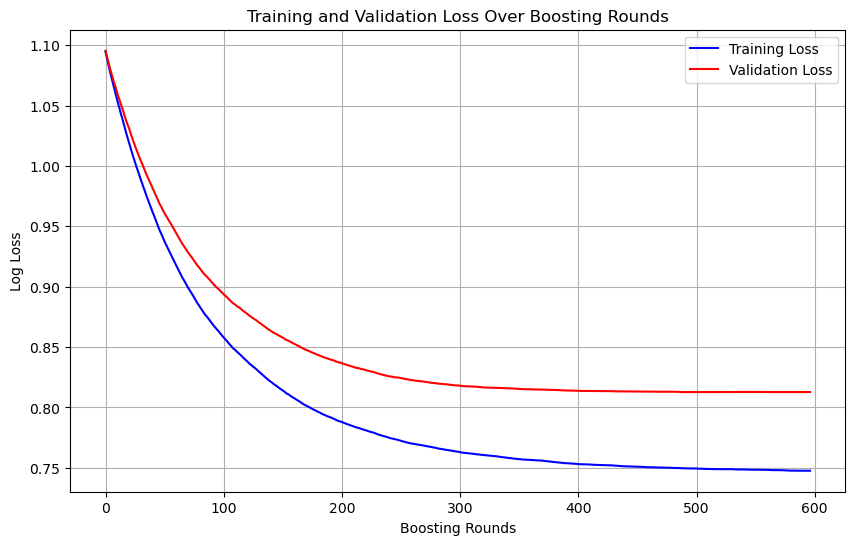

3708

In [107]:
# Extract the training and validation loss
training_loss = evals_result['train']['mlogloss']
validation_loss = evals_result['eval']['mlogloss']

# Plot both the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='red')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()
gc.collect()

# Generating Predictions

Use the trained XGBoost model to generate probability predictions on the training, validation, and test datasets. These probabilities are used to determine the predicted classes.

In [108]:
# Predict on training and test data
y_train_pred_proba = model.predict(dtrain)
y_test_pred_proba = model.predict(dtest)

# Evaluating Precision and Recall Across Thresholds

Analyze how precision and recall for Buy (Class 1) and Sell (Class 2) vary across different probability thresholds. This helps in selecting optimal thresholds for classification. The name of the game here is precision (i.e. what portion of our predictions are correct. Here recall can be low - if we can execute only a handful of trades per day and be confident in those, then we might make profit!

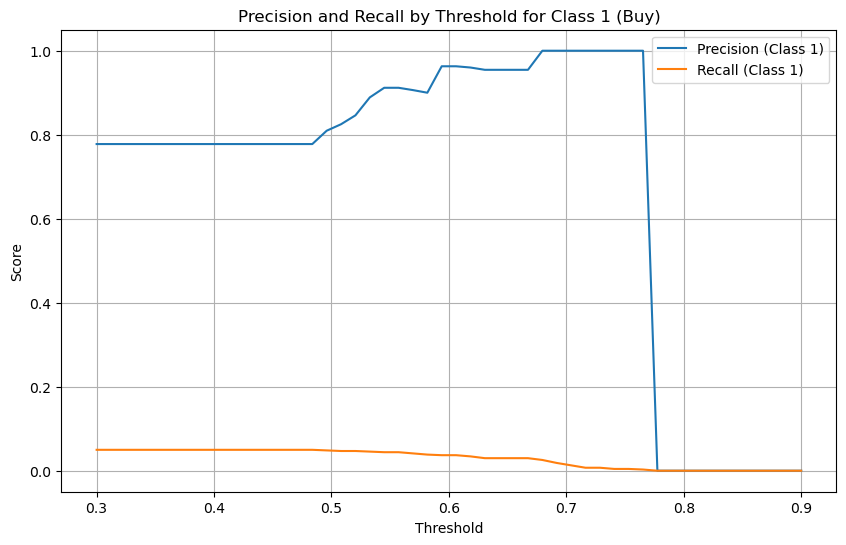

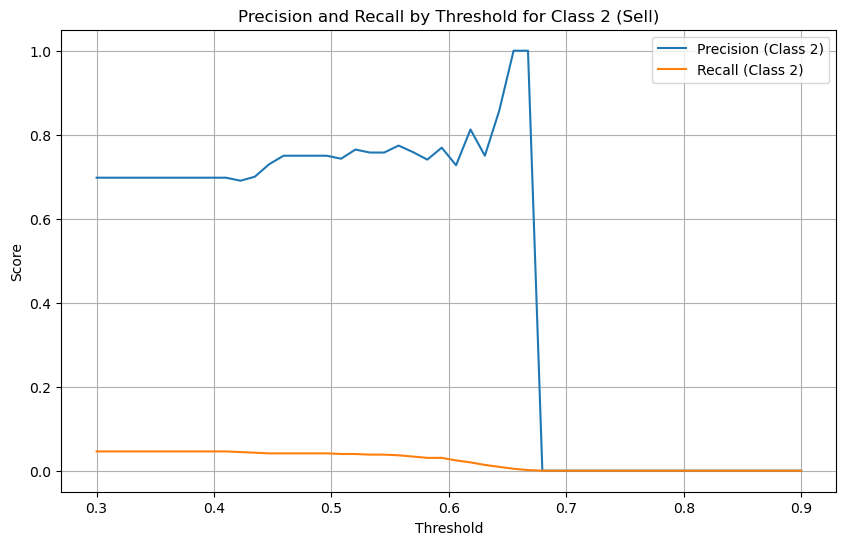

In [109]:
# Precision and Recall for Buy and Sell by threshold prob
# Ensure y_test is a numpy array
if isinstance(y_test, cudf.Series) or isinstance(y_test, cudf.DataFrame):
    y_test_cpu = y_test.to_numpy()  # Convert from cudf to numpy
else:
    y_test_cpu = y_test  

# Define thresholds
thresholds = np.linspace(0.3, 0.9, 50)

# Initialize lists to store precision and recall values for classes 1 and 2
precision_scores_class_1 = []
recall_scores_class_1 = []
precision_scores_class_2 = []
recall_scores_class_2 = []

# Calculate precision and recall for each threshold for class 1 and 2
for threshold in thresholds:
    y_test_pred = np.array([np.argmax(probs) if max(probs) >= threshold else 0 for probs in y_test_pred_proba])
    
    # Calculate precision and recall for class 1
    precision_class_1 = precision_score(y_test_cpu, y_test_pred, labels=[1], average='macro', zero_division=0)
    recall_class_1 = recall_score(y_test_cpu, y_test_pred, labels=[1], average='macro', zero_division=0)
    
    # Calculate precision and recall for class 2
    precision_class_2 = precision_score(y_test_cpu, y_test_pred, labels=[2], average='macro', zero_division=0)
    recall_class_2 = recall_score(y_test_cpu, y_test_pred, labels=[2], average='macro', zero_division=0)
    
    # Append results to the respective lists
    precision_scores_class_1.append(precision_class_1)
    recall_scores_class_1.append(recall_class_1)
    precision_scores_class_2.append(precision_class_2)
    recall_scores_class_2.append(recall_class_2)

# Plot precision and recall for class 1
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores_class_1, label='Precision (Class 1)')
plt.plot(thresholds, recall_scores_class_1, label='Recall (Class 1)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall by Threshold for Class 1 (Buy)')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision and recall for class 2
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores_class_2, label='Precision (Class 2)')
plt.plot(thresholds, recall_scores_class_2, label='Recall (Class 2)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall by Threshold for Class 2 (Sell)')
plt.legend()
plt.grid(True)
plt.show()

# Applying Class-Specific Thresholds for Classification

Define and apply class-specific probability thresholds to convert probability predictions into discrete class labels. This customization allows for different confidence levels when predicting Buy and Sell actions.

In [110]:
# Thresholds for each class
theofld = 0.55  # Threshold for class 1/Buy
theoslh = 0.55  # Threshold for class 2/Sell

# Convert probabilities to class labels with class-specific threshold logic
def classify_with_threshold(probs):
    # Get the predicted class and its probability
    predicted_class = np.argmax(probs)
    max_prob = max(probs)

    # Apply class-specific threshold logic
    if predicted_class == 1 and max_prob >= theofld:
        return 1
    elif predicted_class == 2 and max_prob >= theoslh:
        return 2
    else:
        return 0  # Default class if thresholds are not met

# Convert training and testing probabilities to class labels
y_train_pred = np.array([classify_with_threshold(probs) for probs in y_train_pred_proba])
y_test_pred = np.array([classify_with_threshold(probs) for probs in y_test_pred_proba])

# Predict on validation data
y_valid_pred_proba = model.predict(dvalid)

# Convert validation probabilities to class labels with class-specific threshold logic
y_valid_pred = np.array([classify_with_threshold(probs) for probs in y_valid_pred_proba])

# Generating Classification Reports

Produce detailed classification reports for training, test, and validation datasets. We show metrics such as precision, recall, f1-score, and support for each class.

In [111]:
# Print classification report for training data
print("Classification Report for Training Data:")
print(classification_report(np.asarray(cudf.Series(y_train).to_numpy()), y_train_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Classification Report for Training Data:
              precision    recall  f1-score   support

     Class 0       0.67      0.99      0.80      5998
     Class 1       0.90      0.13      0.23      1612
     Class 2       0.86      0.09      0.17      1714

    accuracy                           0.68      9324
   macro avg       0.81      0.40      0.40      9324
weighted avg       0.74      0.68      0.58      9324


In [112]:
# Print classification report for test data
print("Classification Report for Test Data:")
print(classification_report(np.asarray(cudf.Series(y_test).to_numpy()), y_test_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Classification Report for Test Data:
              precision    recall  f1-score   support

     Class 0       0.64      1.00      0.78      2316
     Class 1       0.91      0.04      0.08       703
     Class 2       0.76      0.04      0.07       653

    accuracy                           0.64      3672
   macro avg       0.77      0.36      0.31      3672
weighted avg       0.71      0.64      0.52      3672


In [113]:
# Print classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(np.asarray(cudf.Series(y_valid).to_numpy()), y_valid_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Class 0       0.64      0.99      0.78      2351
     Class 1       0.86      0.06      0.11       719
     Class 2       0.71      0.04      0.07       674

    accuracy                           0.64      3744
   macro avg       0.74      0.36      0.32      3744
weighted avg       0.69      0.64      0.52      3744


# Analyzing Prediction Accuracy Over Time

Add the predicted classes and correctness indicators to the test DataFrame. This facilitates the analysis of prediction performance over different dates and helps in visualizing correct versus incorrect trades.

In [114]:
# Prepare data for plotting
test_df['predicted_class'] = y_test_pred  # Add the predicted classes to the test DataFrame
test_df['correct'] = (test_df['predicted_class'] == test_df['Y']).astype(int)  # 1 if correct, 0 if incorrect

# Filtering for Buy and Sell Predictions

Extract only the rows where the model predicted Buy (Class 1) or Sell (Class 2) actions. This focus allows for targeted analysis of trading decisions.

In [115]:
# Filter for pred classes 1 and 2
filtered_df = test_df[(test_df['predicted_class'].isin([1, 2]))]

# Aggregating Prediction Results by Date

Group the filtered DataFrame by date and correctness to count the number of correct and incorrect predictions per day. This aggregation aids in understanding daily model performance.

In [116]:
# Extract the date part from the datetime column
filtered_df['DATE'] = filtered_df['DATE'].dt.strftime('%Y-%m-%d')

In [117]:
# Group by DATE,  and correct, then calculate the size of each group
grouped = filtered_df.groupby(['DATE', 'correct']).size().reset_index(name='count')

# Pivoting the Grouped Data for Visualization

Transform the grouped data into a pivot table format, separating correct and incorrect prediction counts. 

In [118]:
# Convert to pandas for pivoting
grouped_pandas = grouped.to_pandas()

In [119]:
# Pivot the table to have correct/incorrect counts in separate columns
pivot_table = grouped_pandas.pivot_table(index='DATE', columns='correct', values='count', fill_value=0)

In [120]:
# Rename columns for clarity
pivot_table.columns = ['Incorrect', 'Correct']

# Visualizing Correct and Incorrect Predictions per Day

Create a stacked bar chart to display the number of correct and incorrect predictions for Buy and Sell actions on a daily basis.

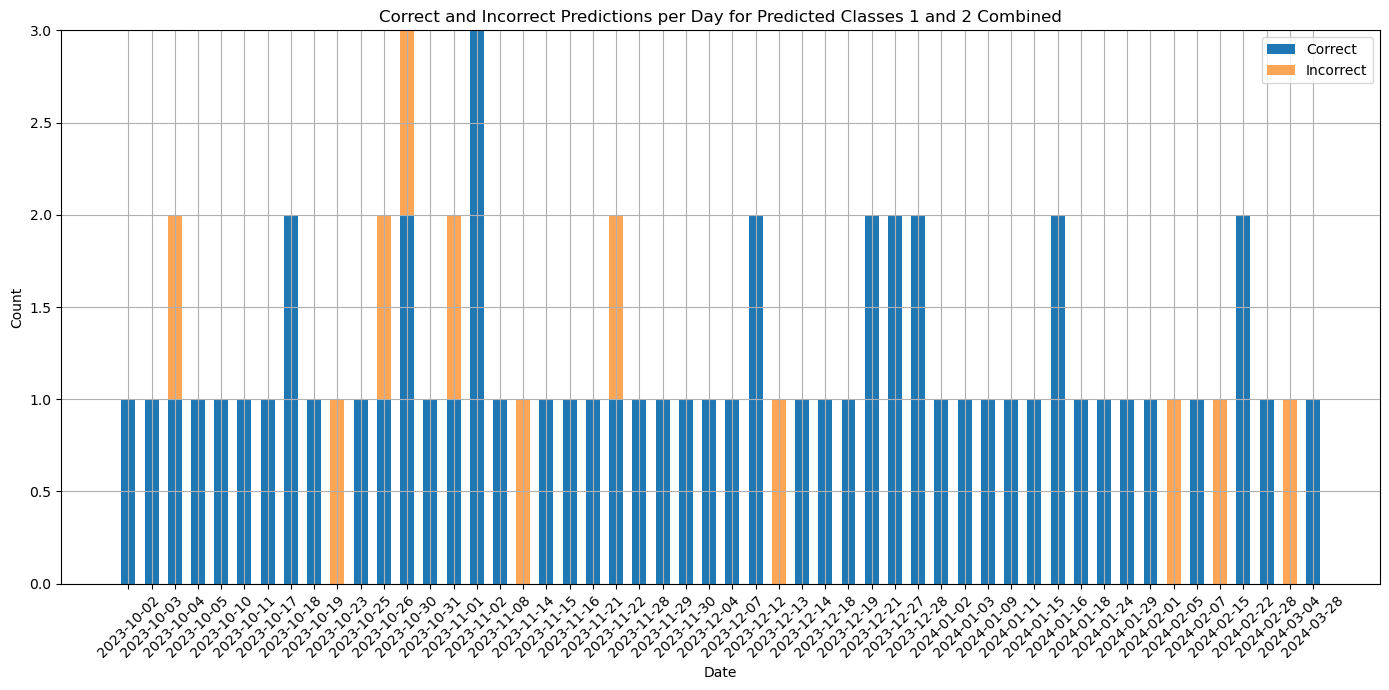

In [121]:
# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Align the data with the dates
dates = pivot_table.index
correct_counts = pivot_table['Correct']
incorrect_counts = pivot_table['Incorrect']

# Plot the bars
ax.bar(dates, correct_counts, label='Correct', width=0.6)
ax.bar(dates, incorrect_counts, bottom=correct_counts, label='Incorrect', width=0.6, alpha=0.7)

# Formatting the plot
ax.set_xticks(np.arange(len(dates)))  # Center the x-ticks between the bars
ax.set_xticklabels(dates, rotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Correct and Incorrect Predictions per Day for Predicted Classes 1 and 2 Combined')
ax.legend()
ax.grid(True)

plt.tight_layout()

# Display the plot
plt.show()

# Calculating Hourly Precision for Buy and Sell Classes

Evaluate the model's precision for Buy (Class 1) and Sell (Class 2) predictions across each hour of the day. This analysis identifies peak performance periods and potential weaknesses in the model.

In [130]:
# Initialize lists to store hourly precision for Buy and Sell
hours = range(24)
buy_precisions = []
sell_precisions = []

# Calculate precision for each hour
for hour in hours:
    # Filter the data for the current hour without adding a new column
    hour_data = test_df[test_df['DATE'].dt.hour == hour]
    
    # Convert the filtered cuDF DataFrame to pandas DataFrame for CPU-based computation
    hour_data_cpu = hour_data.to_pandas()
    
    # Calculate precision for Buy (class 1)
    if len(hour_data_cpu) > 0:  # Ensure there's data for the hour
        y_true = hour_data_cpu['Y']
        y_pred = hour_data_cpu['predicted_class']

        # Calculate precision for "Buy" (class 1)
        if 1 in y_true.unique() or 1 in y_pred.unique():
            buy_precision = precision_score(y_true == 1, y_pred == 1, average='binary', zero_division=0)
        else:
            buy_precision = np.nan

        # Calculate precision for "Sell" (class 2)
        if 2 in y_true.unique() or 2 in y_pred.unique():
            sell_precision = precision_score(y_true == 2, y_pred == 2, average='binary', zero_division=0)
        else:
            sell_precision = np.nan
    else:
        buy_precision = np.nan
        sell_precision = np.nan
    
    # Print results for the hour if inside our trading hours
    if hour>=14 and hour<=15:
        print(f"Hour {hour}: Buy Precision = {buy_precision:.4f}, Sell Precision = {sell_precision:.4f}") 

Hour 14: Buy Precision = 0.8333, Sell Precision = 0.6667
Hour 15: Buy Precision = 0.9286, Sell Precision = 0.7667


# Simulating Trading Strategy Performance

Simulate trading based on the model's predictions to evaluate the strategy's effectiveness. Track correct trades, total trades, and capital progression over time to calculate performance metrics such as average daily return, standard deviation, and Sharpe Ratio.

In [131]:
# Parameters to specify the time windows for Buy and Sell predictions
buy_start_hour = 14   # Start at 2 PM
buy_end_hour = 15     # End at 3 PM
sell_start_hour = 14  # Start at 2 PM
sell_end_hour = 15    # End at 3 PM

# Initialize variables to track correct trades, total trades, and trades per day
correct_trades = 0
total_trades = 0
trades_per_day = defaultdict(int)  # Dictionary to track the number of trades per day

# List to hold the progression of values and corresponding dates
values = [initial_value]
trade_dates = []
last_trade_time = None  # Initialize a variable to keep track of the last trade time
last_date = None  # Initialize a variable to keep track of the last processed date
trades_today = 0  # Initialize a counter for trades per day

# Iterate through the test predictions and actual values
for i in range(len(y_test_pred)):
    current_datetime = pd.Timestamp(test_df['DATE'].iloc[i])  # Get the current datetime
    current_date = current_datetime.date()  # Extract just the date part
    current_hour = current_datetime.hour   # Extract the hour part

    if current_date != last_date:  # Reset trade counter at the start of a new day
        trades_today = 0
        last_date = current_date
        last_trade_time = None  # Reset last trade time for the new day

    # Check if the trade is within the specified time window
    if (y_test_pred[i] == 1 and buy_start_hour <= current_hour < buy_end_hour) or \
       (y_test_pred[i] == 2 and sell_start_hour <= current_hour < sell_end_hour):

        # Check if enough time has passed since the last trade
        if trades_today < max_trades_per_day and \
           (last_trade_time is None or (current_datetime - last_trade_time) >= timedelta(hours=min_hours_between_trades)):
            
            total_trades += 1  # Increment the total trades counter
            trades_per_day[current_date] += 1  # Increment the trade count for the day
            
            if y_test_pred[i] == test_df['Y'].iloc[i]:  # Correct prediction
                correct_trades += 1  # Increment the correct trades counter
                new_value = values[-1] * (1 + leverage * PT)
            else:  # Incorrect prediction
                new_value = values[-1] * (1 - leverage * SL)
                
            values.append(new_value)
            trade_dates.append(current_date)  # Store the date of the trade 
            trades_today += 1  # Increment the counter after each trade
            last_trade_time = current_datetime  # Update the last trade time

# Calculate daily returns (as percentage change)
daily_returns = np.diff(values) / np.array(values[:-1]) * 100

# Calculate average daily return and standard deviation
average_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)

# Calculate the proportion of correct trades
if total_trades > 0:
    correct_trade_ratio = correct_trades / total_trades

# Calculate the average number of trades per day
if len(trades_per_day) > 0:
    avg_trades_per_day = sum(trades_per_day.values()) / len(trades_per_day)

# Calculate the Sharpe Ratio
if std_dev_daily_return != 0:
    sharpe_ratio = (np.sqrt(trading_days_per_year) * average_daily_return) / std_dev_daily_return

# Estimate end value after number of years
total_trading_days = trading_days_per_year * years

# Calculate the end value using compound interest formula with safety factor
end_value = initial_value * (1 + 0.9 * average_daily_return / 100) ** total_trading_days  # Include 90% as safety factor

# Setting Up Monte Carlo Simulation Parameters

Initialize parameters for the Monte Carlo simulation, including initial capital, trade probabilities, leverage, and the number of simulation runs. This simulation estimates the potential distribution of future capital based on trading performance.

In [132]:
# Simulation parameters
initial_capital = initial_value
integer_trades_per_day = int(np.floor(avg_trades_per_day))  # Integer part of trades per day
fractional_trade_probability = avg_trades_per_day - integer_trades_per_day  # Fractional part as a probability

# Extract precision values for Class 1 and Class 2 from the test set classification report
report_dict = classification_report(np.asarray(cudf.Series(y_test).to_numpy()), y_test_pred, target_names=['Class 0', 'Class 1', 'Class 2'], output_dict=True)
precision_class_1 = report_dict['Class 1']['precision']
precision_class_2 = report_dict['Class 2']['precision']
print(f"Win Rate Buy: {precision_class_1:.2%}")
print(f"Win Rate Sell: {precision_class_2:.2%}")

# Calculate the win rate as the average of precision for Class 1 and Class 2
win_rate = (precision_class_1 + precision_class_2)*0.9 / 2 # include 90% as safety factor
gain_per_trade = PT
loss_per_trade = SL
leverage_ratio = leverage
num_days = int(np.floor(trading_days_per_year * years))
num_simulations = 5000

# Adjust gains and losses for leverage
leveraged_gain_per_trade = leverage_ratio * gain_per_trade
leveraged_loss_per_trade = leverage_ratio * loss_per_trade

Win Rate Buy: 91.18%
Win Rate Sell: 75.76%


# Running Monte Carlo Simulations

Perform Monte Carlo simulations to project the distribution of final capital after a specified number of years. Each simulation randomly determines the outcome of trades based on the win rate and leverage, providing insights into potential financial performance. Also create a histogram to display the distribution of final capital amounts after the simulation period. This visualization helps in understanding the range and frequency of possible financial outcomes.

Expected value after 7 years: $18,440
Median value after 7 years: $18,148
Max value after 7 years: $30,771
Min value after 7 years: $9,724


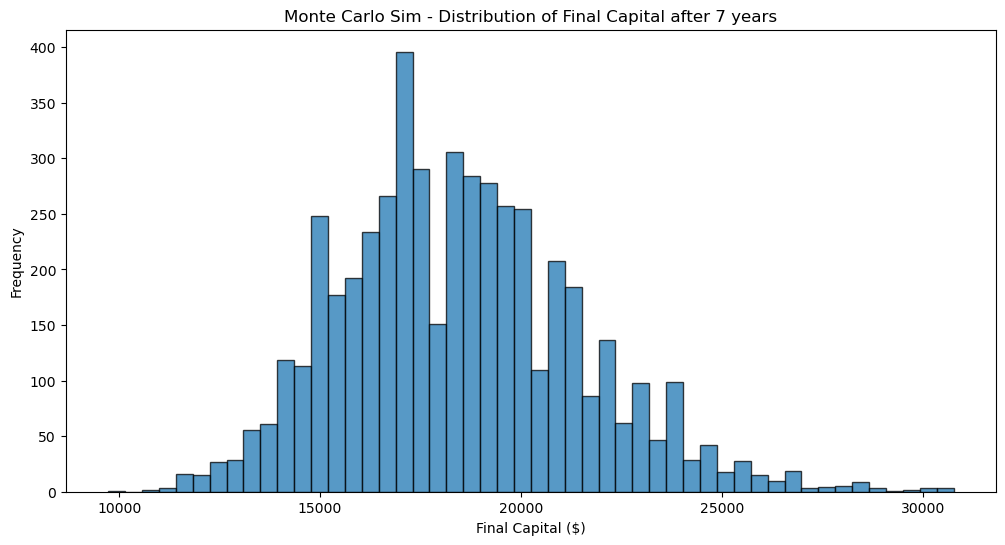

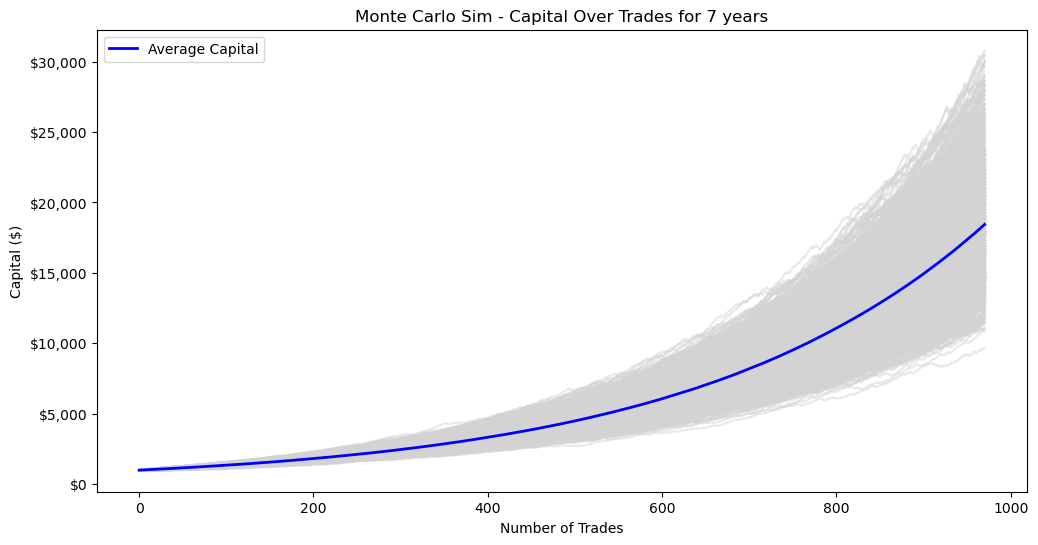

In [133]:
# Monte Carlo simulation 
all_capitals = []
final_capitals_years = []

for _ in range(num_simulations):
    capital = initial_capital
    capitals = [capital]
    for _ in range(num_days):
        daily_return = 1
        # Perform the integer number of trades
        for _ in range(integer_trades_per_day):
            if np.random.rand() < win_rate:
                daily_return *= (1 + leveraged_gain_per_trade)
            else:
                daily_return *= (1 - leveraged_loss_per_trade)
        
        # Determine whether to perform an additional trade based on the fractional part
        if np.random.rand() < fractional_trade_probability*0.5:
            if np.random.rand() < win_rate:
                daily_return *= (1 + leveraged_gain_per_trade)
            else:
                daily_return *= (1 - leveraged_loss_per_trade)
        
        capital *= daily_return
        capitals.append(capital if capital > 0 else 0)
    all_capitals.append(capitals)
    final_capitals_years.append(capital)

# Calculate expected value 
expected_value_years = np.mean(final_capitals_years)
print(f"Expected value after {years} years: ${expected_value_years:,.0f}")
print(f"Median value after {years} years: ${np.median(final_capitals_years):,.0f}")
print(f"Max value after {years} years: ${np.max(final_capitals_years):,.0f}")
print(f"Min value after {years} years: ${np.min(final_capitals_years):,.0f}")

# Define a formatter function for the y-axis
def currency(x, pos):
    'The two args are the value and tick position'
    return f'${x:,.0f}'

formatter = FuncFormatter(currency)

# Plotting the distribution of final capitals
plt.figure(figsize=(12, 6))
plt.hist(final_capitals_years, bins=50, edgecolor='k', alpha=0.75)
plt.title(f"Monte Carlo Sim - Distribution of Final Capital after {years} years")
plt.xlabel('Final Capital ($)')
plt.ylabel('Frequency')
plt.show()

# Calculate the average capital per trade
average_capital_per_trade = np.mean(all_capitals, axis=0)

# Plotting the capital over trades for each simulation
plt.figure(figsize=(12, 6))

# Plot all simulation paths
for capitals in all_capitals:
    plt.plot(capitals, color='lightgray', alpha=0.5)

# Plot the average capital per trade
plt.plot(average_capital_per_trade, color='blue', linewidth=2, label='Average Capital')

plt.title(f"Monte Carlo Sim - Capital Over Trades for {years} years")
plt.xlabel('Number of Trades')
plt.ylabel('Capital ($)')
plt.gca().yaxis.set_major_formatter(formatter)  # Apply the formatter
plt.legend()
plt.show()

# Check Feature Importance

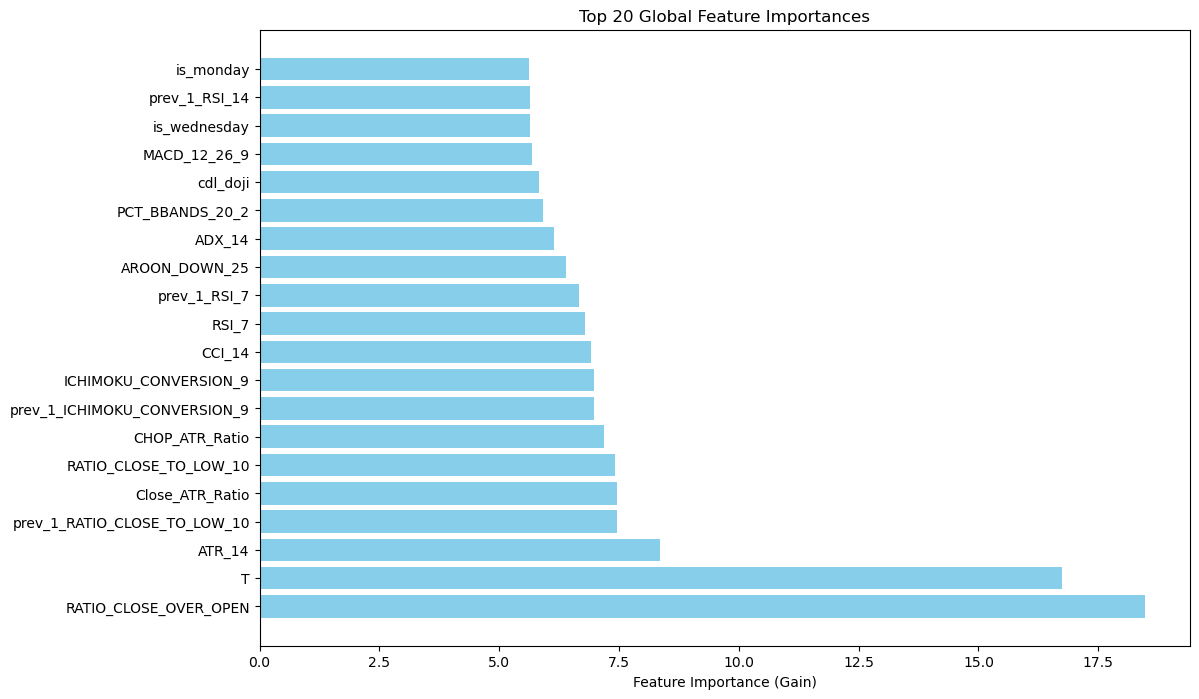

In [134]:
# Retrieve the booster from the trained model
booster = model  # No need for .get_booster()

# ---------------------
# Global Feature Importance
# ---------------------

# Choose the importance type
importance_type = 'gain'  # Options: 'weight', 'gain', 'cover'

# Extract global feature importance
feature_importance = booster.get_score(importance_type=importance_type)

# Convert to pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot Top 20 Features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='skyblue')
plt.xlabel(f'Feature Importance ({importance_type.capitalize()})')
plt.title('Top 20 Global Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [144]:
gc.collect()
print('Done!')

Done!
